# 0.0. Imports

In [1]:
import random
import pickle
import datetime
import inflection

import pandas            as pd
import numpy             as np
import seaborn           as sns
import xgboost           as xgb
import matplotlib.pyplot as plt

from scipy                import stats  as ss
from sklearn              import preprocessing as pp
from sklearn              import ensemble as en
from sklearn              import metrics as mt
from sklearn              import linear_model as lm

from math                 import isnan
from boruta               import BorutaPy
from tabulate             import tabulate
from IPython.core.display import HTML

## 0.1. Helper Functions

In [2]:
def cross_validation_ts( x_training, kfold, model, verbose=False):

    mae_list = list()
    mape_list = list()
    rmse_list = list()
    
    for k in reversed( range( 1, kfold+1 ) ):

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( weeks=k*6 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( weeks=(k-1)*6 )
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        result = ml_error( 'Linear Regression', np.expm1( yvalidation ), np.expm1( yhat ) )
        
        if verbose:
            print( f'KFold Number {k}' )
            print( result, end='\n\n' )
    
        # Store performance of each kfold iteration
        mae_list.append( result.loc[0, 'MAE'] )
        mape_list.append( result.loc[0, 'MAPE'] )
        rmse_list.append( result.loc[0, 'RMSE'] )
    
        # return DataFrame
    
    return pd.DataFrame( {
                'Model Name': m.__class__.__name__,
                'MAE CV': str( np.round( np.mean( mae_list ), 2 ) ) + ' ± ' + str( np.round( np.std( mae_list ), 2 ) ),
                'MAPE CV': str( np.round( np.mean( mape_list ), 4 ) ) + ' ± ' + str( np.round( np.std( mape_list ), 4 ) ),
                'RMSE CV': str( np.round( np.mean( rmse_list ), 2 ) ) + ' ± ' + str( np.round( np.std( rmse_list ), 2 ) )},
                        index=[0]
    )

In [3]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

In [4]:
def ml_error( model_name, y, yhat ):
    mae = mt.mean_absolute_error( y, yhat )
    mape = mt.mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mt.mean_squared_error( y, yhat ) )

    return pd.DataFrame( {
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse}, index=[0] )

In [5]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - ( k - 1 )*( r - 1 )/( n - 1 ) )

    kcorr = k - ( k - 1 )**2/( n - 1 )
    rcorr = r - ( r - 1 )**2/( n - 1 )

    return np.sqrt( ( chi2corr/n ) / ( min( kcorr - 1, rcorr - 1 ) ) )

In [6]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [7]:
jupyter_settings()

## 0.2. Loading data

In [2]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False )

# Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [9]:
del df_sales_raw, df_store_raw

# 1.0. DESCRIÇÃO DOS DADOS

In [10]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [11]:
cols_old = list(df1.columns)

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

In [12]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [13]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Rows: {df1.shape[1]}' )

Number of Rows: 1017209
Number of Rows: 18


## 1.3. Data Types

In [14]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fill out NA

In [16]:
# competition_distance

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if isnan( x ) else x )

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply( 
    lambda x: x['date'].month 
        if isnan( x['competition_open_since_month'] ) 
        else x['competition_open_since_month'],
    axis=1
)

# competition_open_since_year

df1['competition_open_since_year'] = df1.apply( 
    lambda x: x['date'].year 
        if isnan( x['competition_open_since_year'] ) 
        else x['competition_open_since_year'],
    axis=1
)


# promo2_since_week

df1['promo2_since_week'] = df1.apply( 
    lambda x: x['date'].week 
        if isnan( x['promo2_since_week'] ) 
        else x['promo2_since_week'],
    axis=1
)

# promo2_since_year

df1['promo2_since_year'] = df1.apply( 
    lambda x: x['date'].year
        if isnan( x['promo2_since_year'] ) 
        else x['promo2_since_year'],
    axis=1
)

# promo_interval

month_map = { 1: 'Jan', 2: ' Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'
            }

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 
        if x['month_map'] in x['promo_interval'].split( ',' ) else 0,
    axis=1 
)

In [17]:
del month_map

In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [22]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [23]:
#  Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


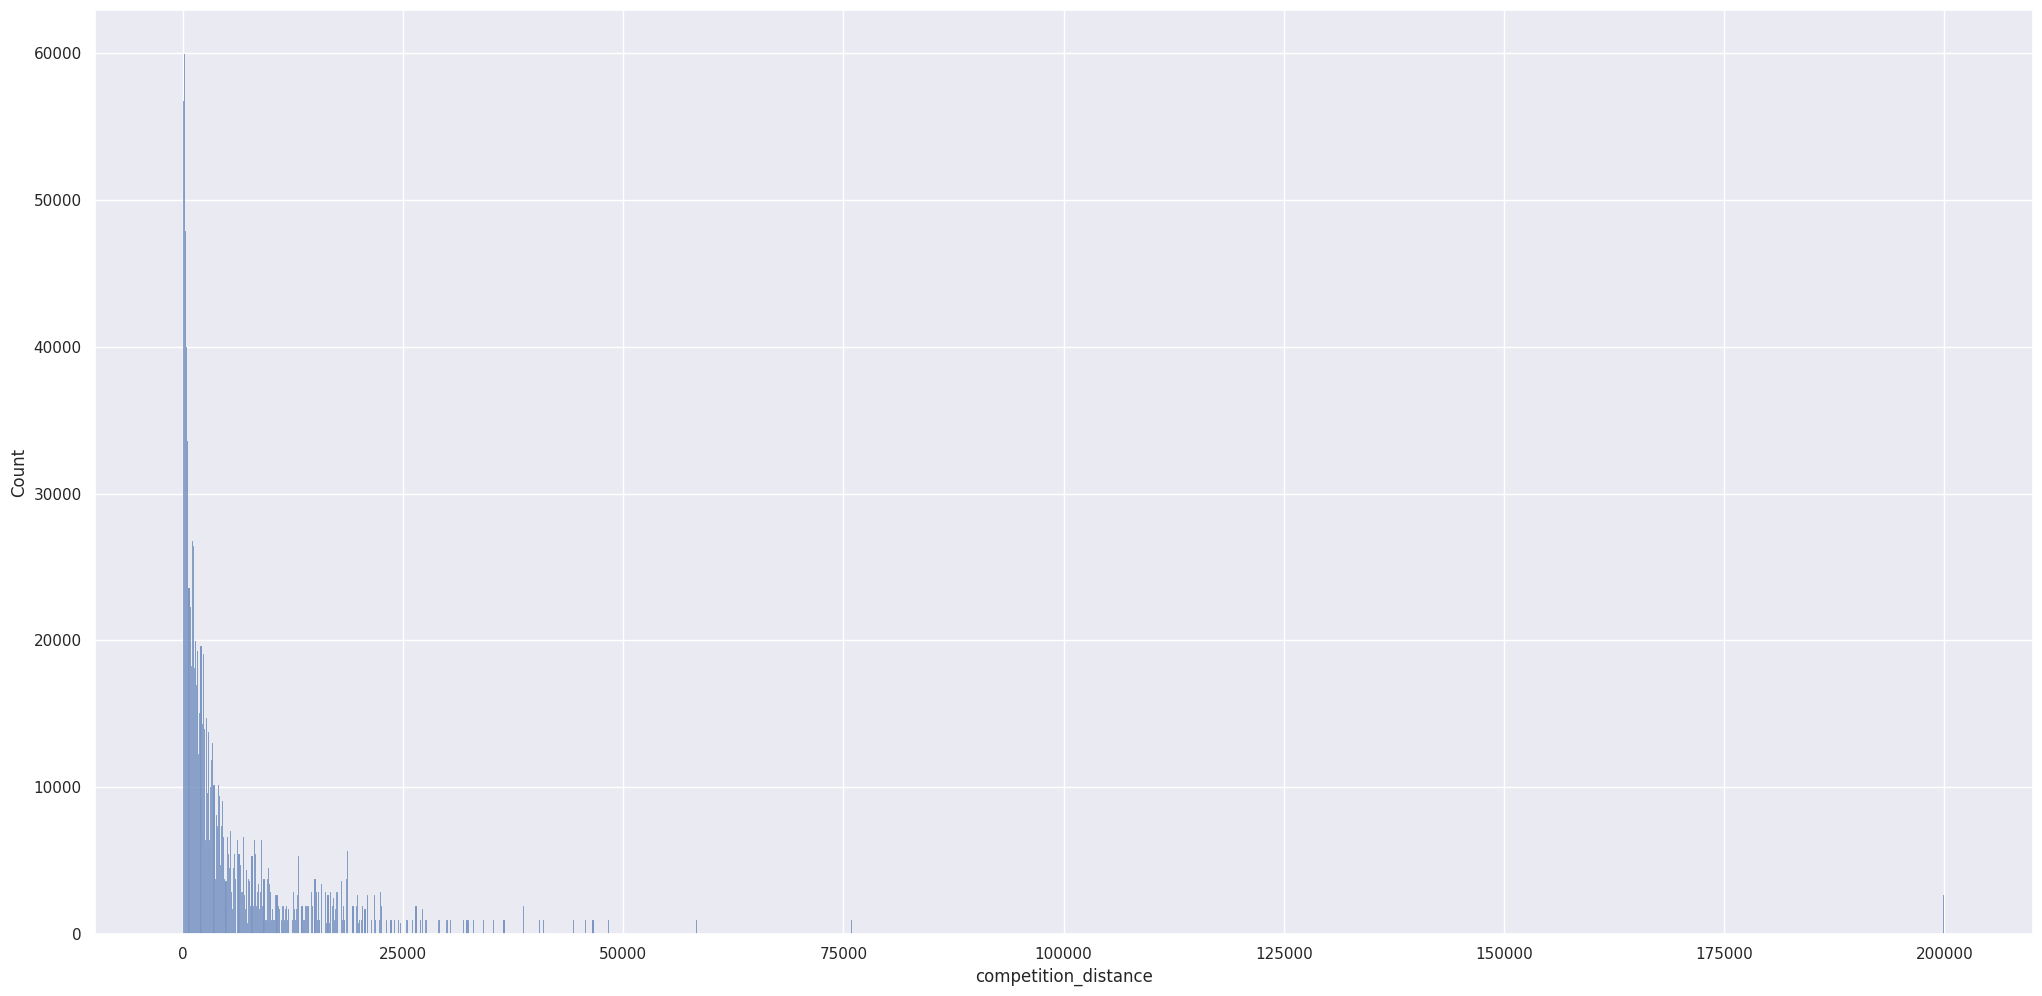

In [24]:
sns.histplot( df1['competition_distance'] );

In [25]:
del ct1, ct2, d1, d2, d3, d4, d5, d6, num_attributes

### 1.7.2. Categorical Attributes

In [26]:
cat_attributes.apply( lambda x: x.nunique() )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

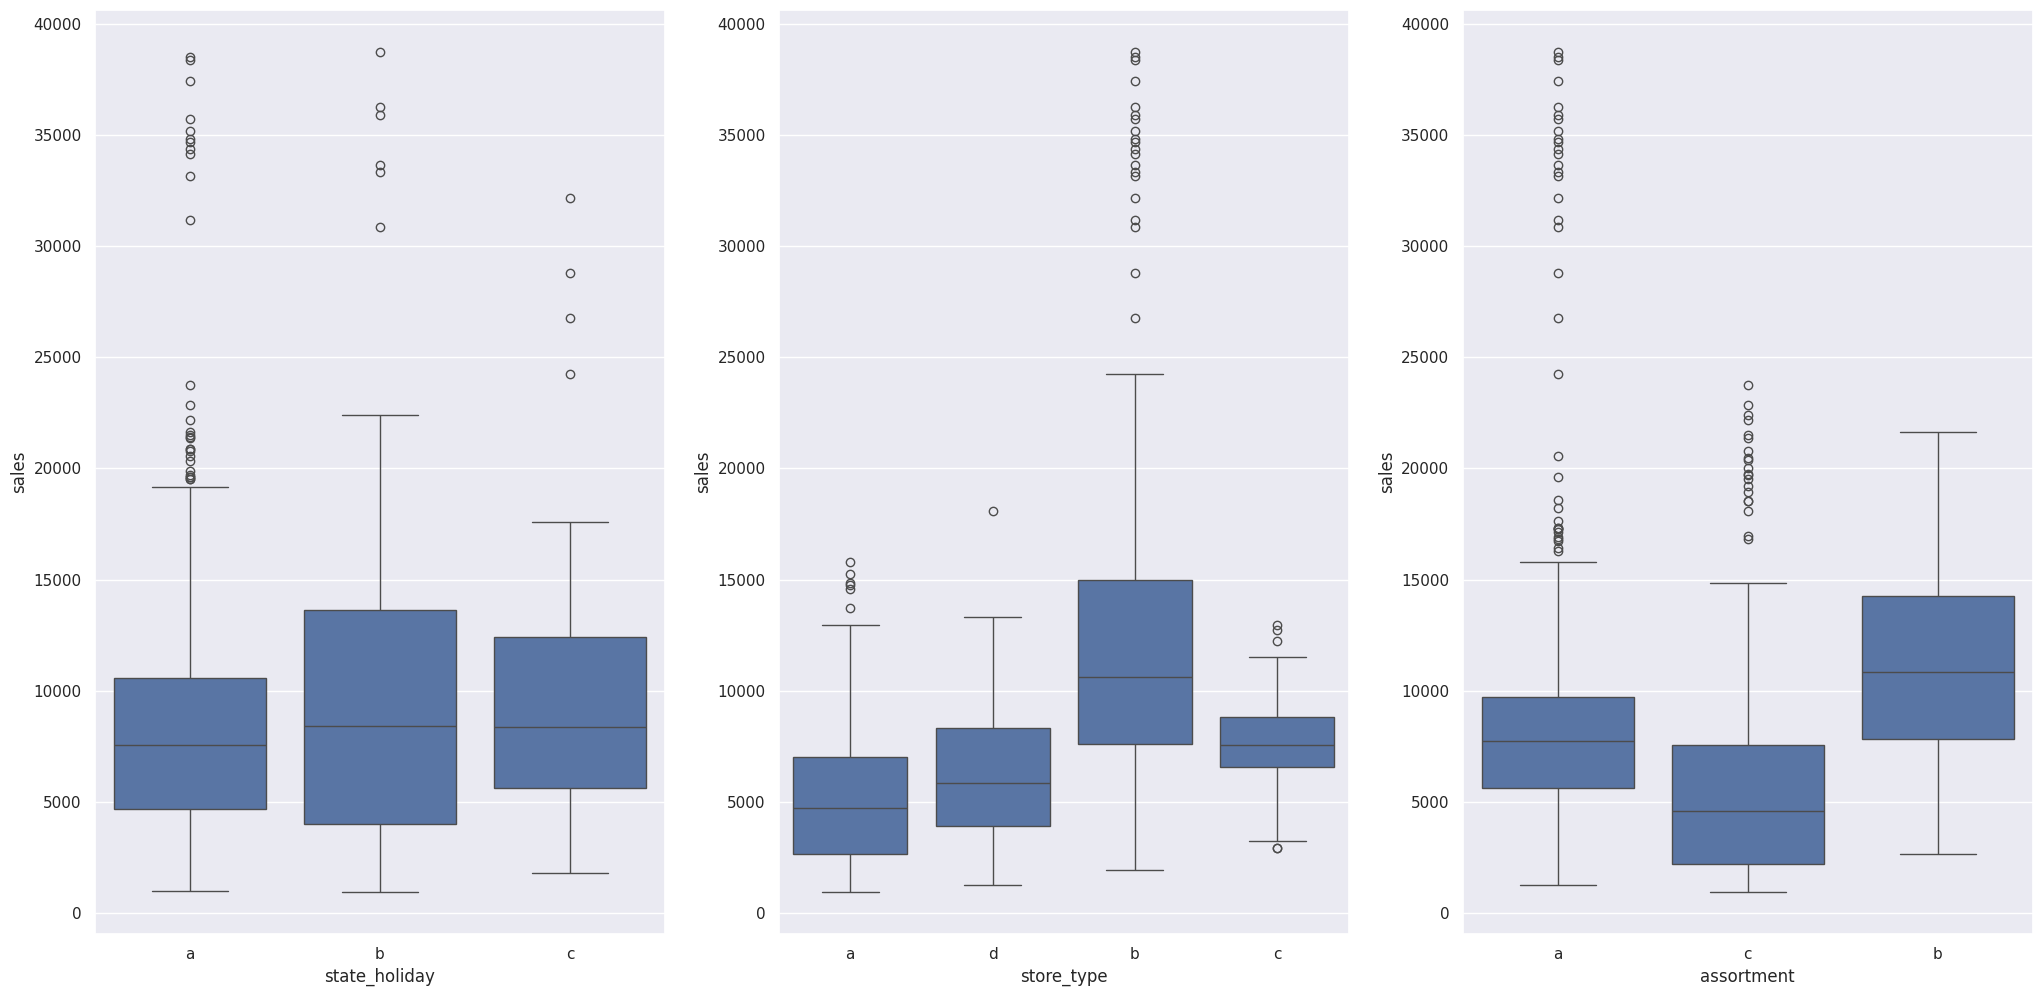

In [27]:
aux = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]


plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux )

In [28]:
del cat_attributes

# 2.0. FEATURE ENGINEERING

In [29]:
df2 = df1.copy()
del df_raw

## 2.1. Mapa Mental de Hipóteses

### 2.1.1. Mapa Mental

![Texto Alternativo](../img/Mind_MapHypothesis.png)

## 2.2. Criação de Hipóteses

### 2.2.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores à mais tempo deveriam vender menos

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender menos

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**7.** Lojas deveriam vender mais ao longo dos anos.

**8.** Lojas deveriam vender mais no segundo semestre do ano.

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**10.** Lojas deveriam vender menos aos finais de semana.

**11.** Lojas deveriam vender menos durante feriados escolares.

## 2.4. Feature Engineering

In [30]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime.datetime( 
        year=x['competition_open_since_year'],
        month=x['competition_open_since_month'],
        day=1
    ),
    axis=1
)
df2['competition_time_month'] = ( 
    ( df2['date'] - df2['competition_since'] ) / 30 
    ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assortment
assortment_map = {
    'a': 'basic',
    'b': 'extra',
    'c': 'extended'
}
df2['assortment'] = df2['assortment'].map(assortment_map)

# state holiday
state_holiday_map = {
    'a': 'public holiday',
    'b': 'Easter holiday',
    'c': 'Christmas',
    '0': 'regular_day'
}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_map)

In [31]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [32]:
df3 = df2.copy()
del df1

## 3.1 - Filtragem das Linhas

In [33]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2 - Seleção das Colunas

In [34]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

In [36]:
df4 = df3.copy()
del df2

## 4.1. Análise Univariada

### 4.1.1. Response Variable

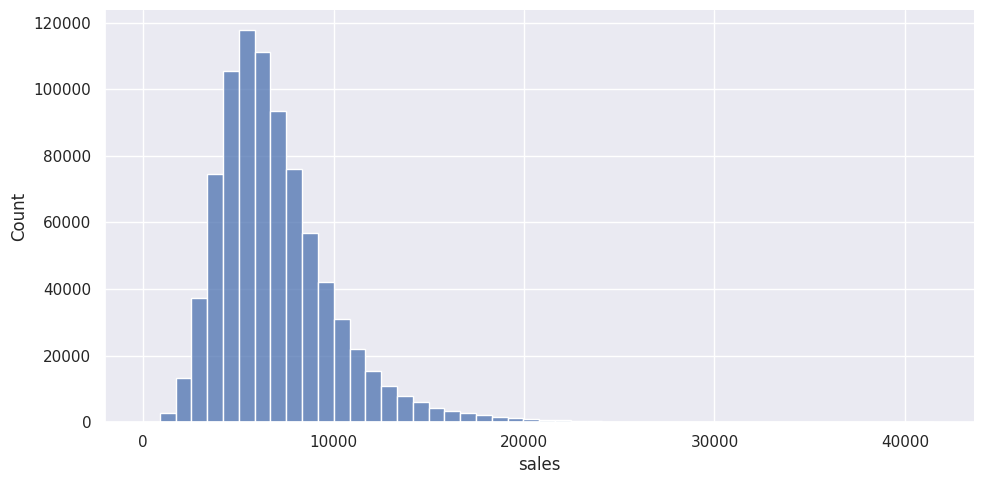

In [37]:
sns.displot( df4['sales'], kde=False, bins=50, aspect=2);

### 4.1.2. Numerical Variable

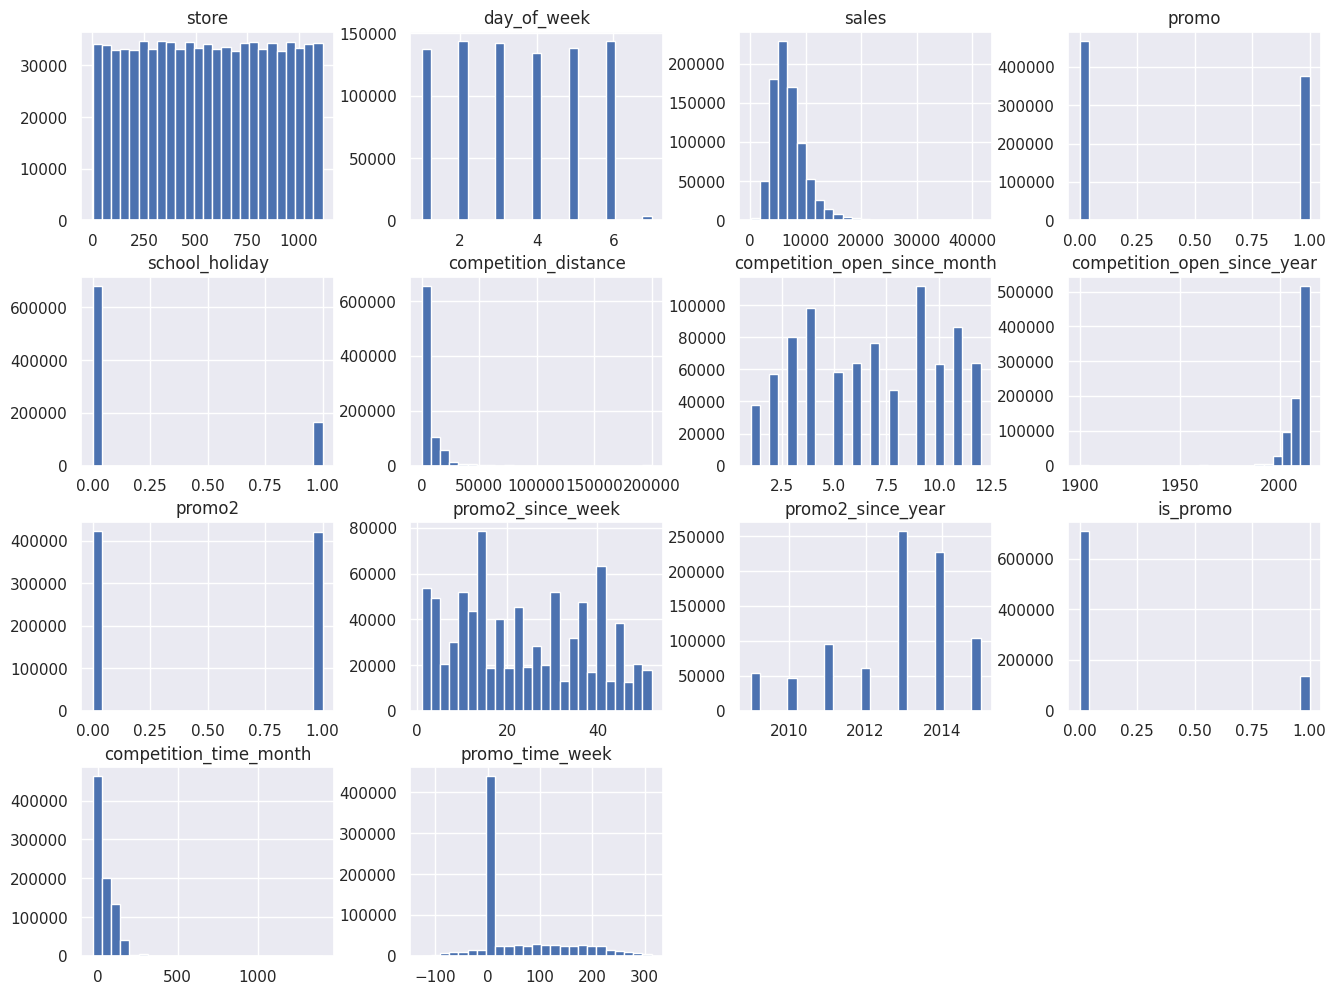

In [38]:
num_attributes = df4.select_dtypes( include=['int64', 'float64'] )
num_attributes.hist( bins=25, figsize=(16,12) );

### 4.1.3. Categorical Variable

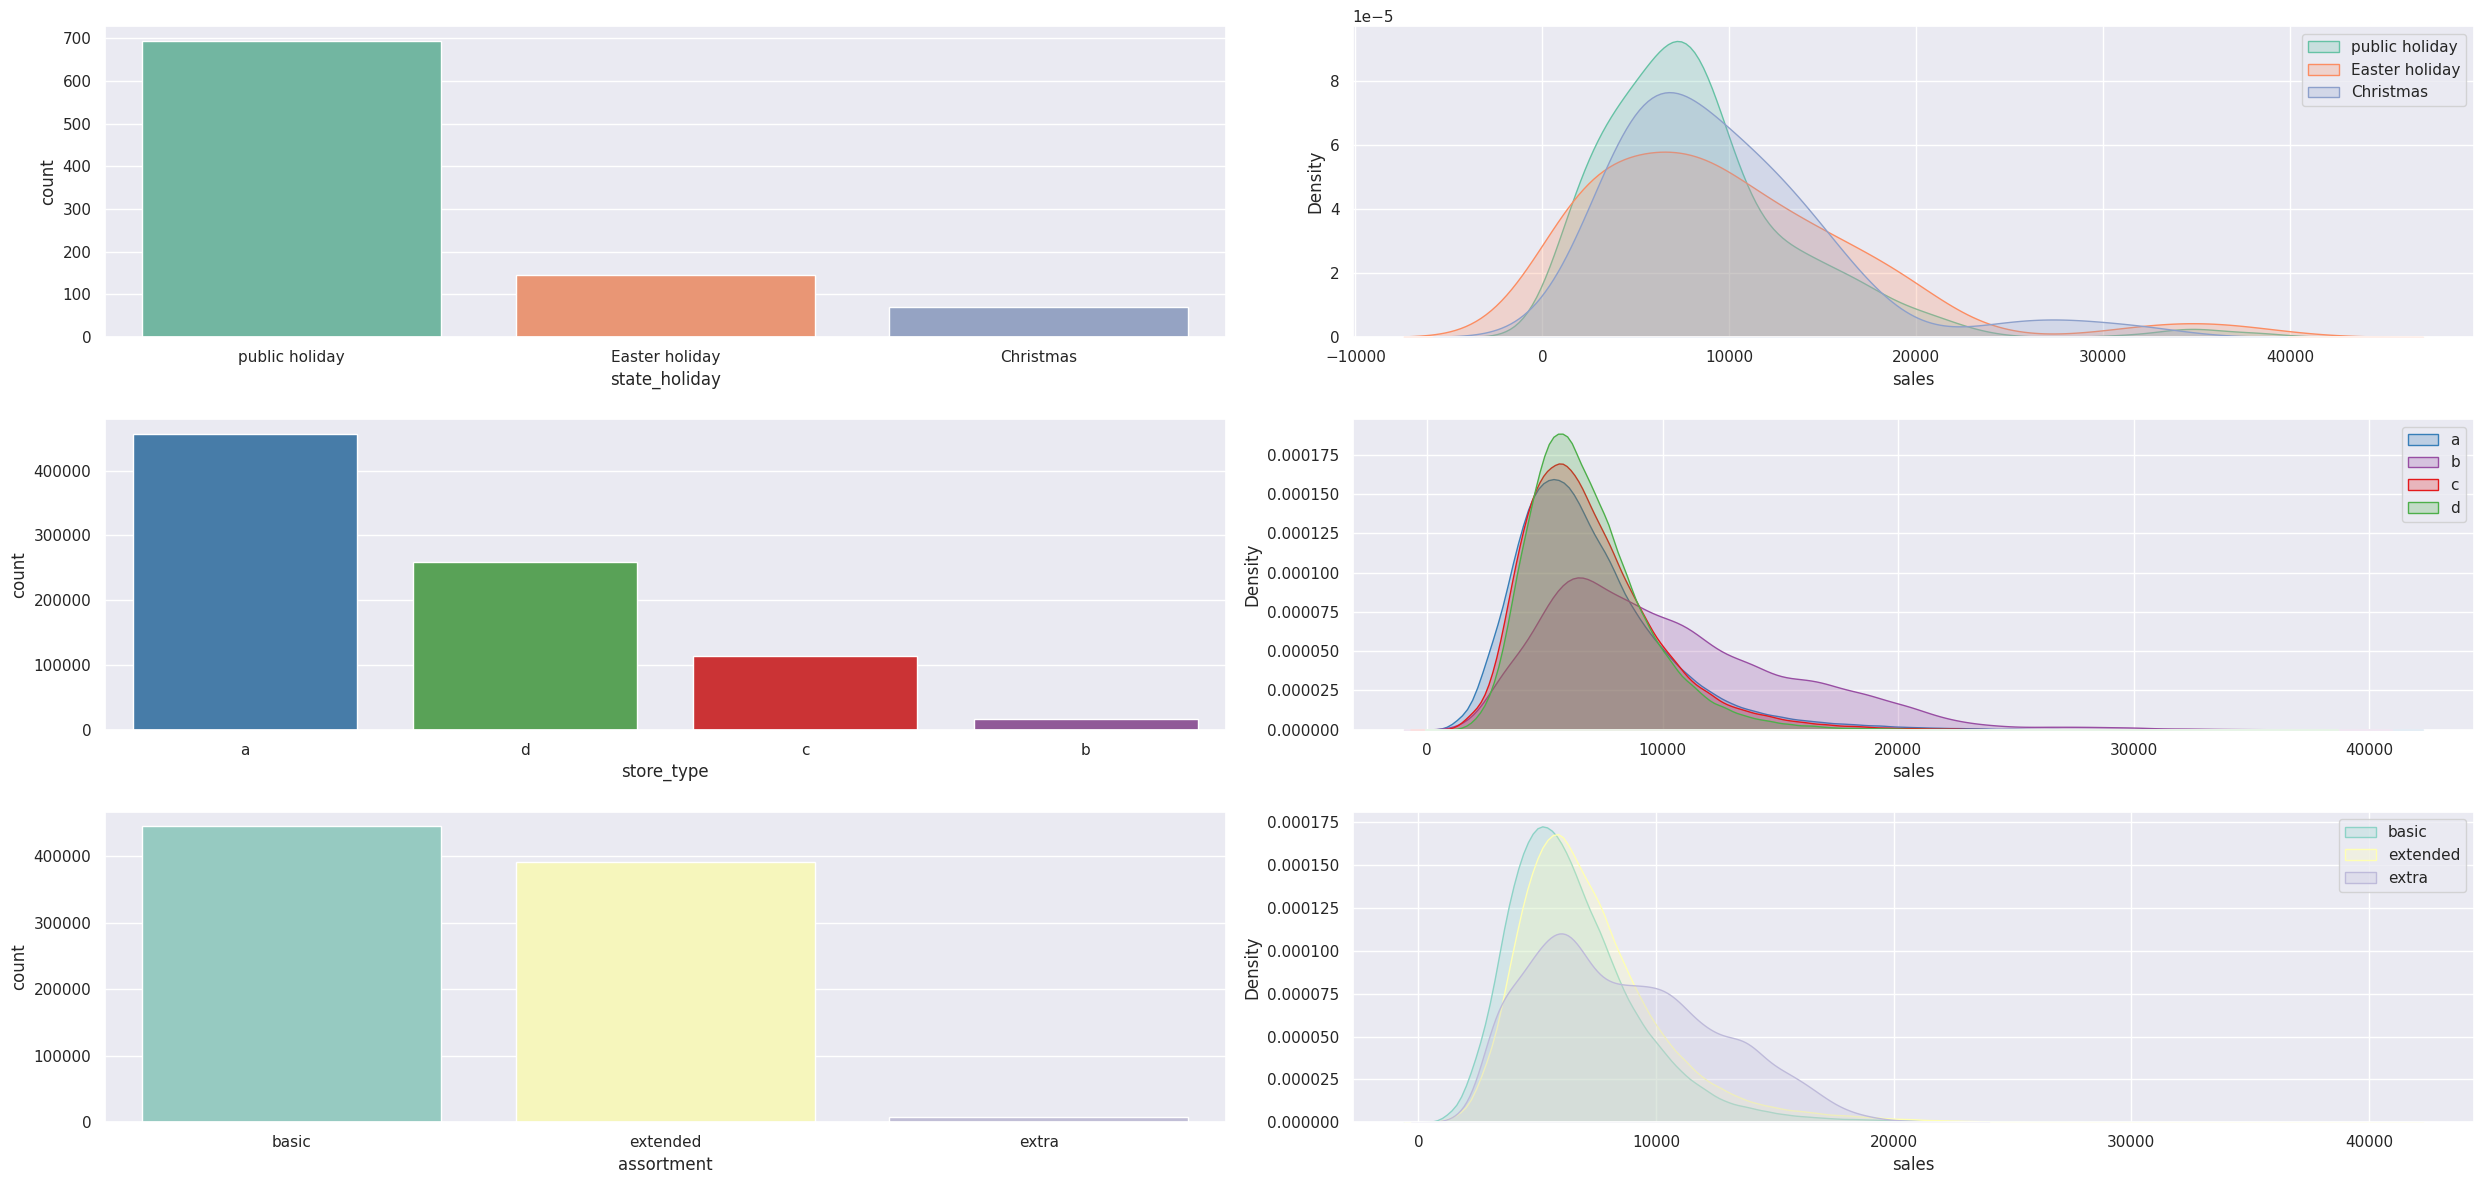

In [39]:
fig, axs = plt.subplots(3, 2, sharex=False)

# state_holiday
df_aux = df4[df4['state_holiday'] != 'regular_day']

sns.countplot( data=df_aux, x='state_holiday', hue='state_holiday', palette='Set2', ax=axs[0, 0] )

sns.kdeplot( data=df4[df4['state_holiday'] == 'public holiday'], x='sales', color='#66c2a5', fill=True, label='public holiday', ax=axs[0, 1] )
sns.kdeplot( data=df4[df4['state_holiday'] == 'Easter holiday'], x='sales', color='#fc8d62', fill=True, label='Easter holiday', ax=axs[0, 1] )
sns.kdeplot( data=df4[df4['state_holiday'] == 'Christmas'], x='sales', color='#8da0cb', fill=True, label='Christmas', ax=axs[0, 1] )
axs[0, 1].legend()

# store_type
sns.countplot( data=df4, x='store_type', hue='store_type', palette='Set1', ax=axs[1, 0], order=df4['store_type'].value_counts().index )

sns.kdeplot( data=df4[df4['store_type'] == 'a'], x='sales', color='#377eb8', fill=True, label='a', ax=axs[1, 1])
sns.kdeplot( data=df4[df4['store_type'] == 'b'], x='sales', color='#984ea3', fill=True, label='b', ax=axs[1, 1] )
sns.kdeplot( data=df4[df4['store_type'] == 'c'], x='sales', color='#e41a1c', fill=True, label='c', ax=axs[1, 1] )
sns.kdeplot( data=df4[df4['store_type'] == 'd'], x='sales', color='#4daf4a', fill=True, label='d', ax=axs[1, 1] )
axs[1, 1].legend()

# assortment
sns.countplot( data=df4, x='assortment', hue='assortment', palette='Set3', ax=axs[2, 0], order=df4['assortment'].value_counts().index )

sns.kdeplot( data=df4[df4['assortment'] == 'basic'], x='sales', color='#8dd3c7', fill=True, label='basic', ax=axs[2, 1])
sns.kdeplot( data=df4[df4['assortment'] == 'extended'], x='sales', color='#ffffb3', fill=True, label='extended', ax=axs[2, 1] )
sns.kdeplot( data=df4[df4['assortment'] == 'extra'], x='sales', color='#bebada', fill=True, label='extra', ax=axs[2, 1] )
axs[2, 1].legend()

plt.tight_layout(h_pad=1.8)
plt.show();

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

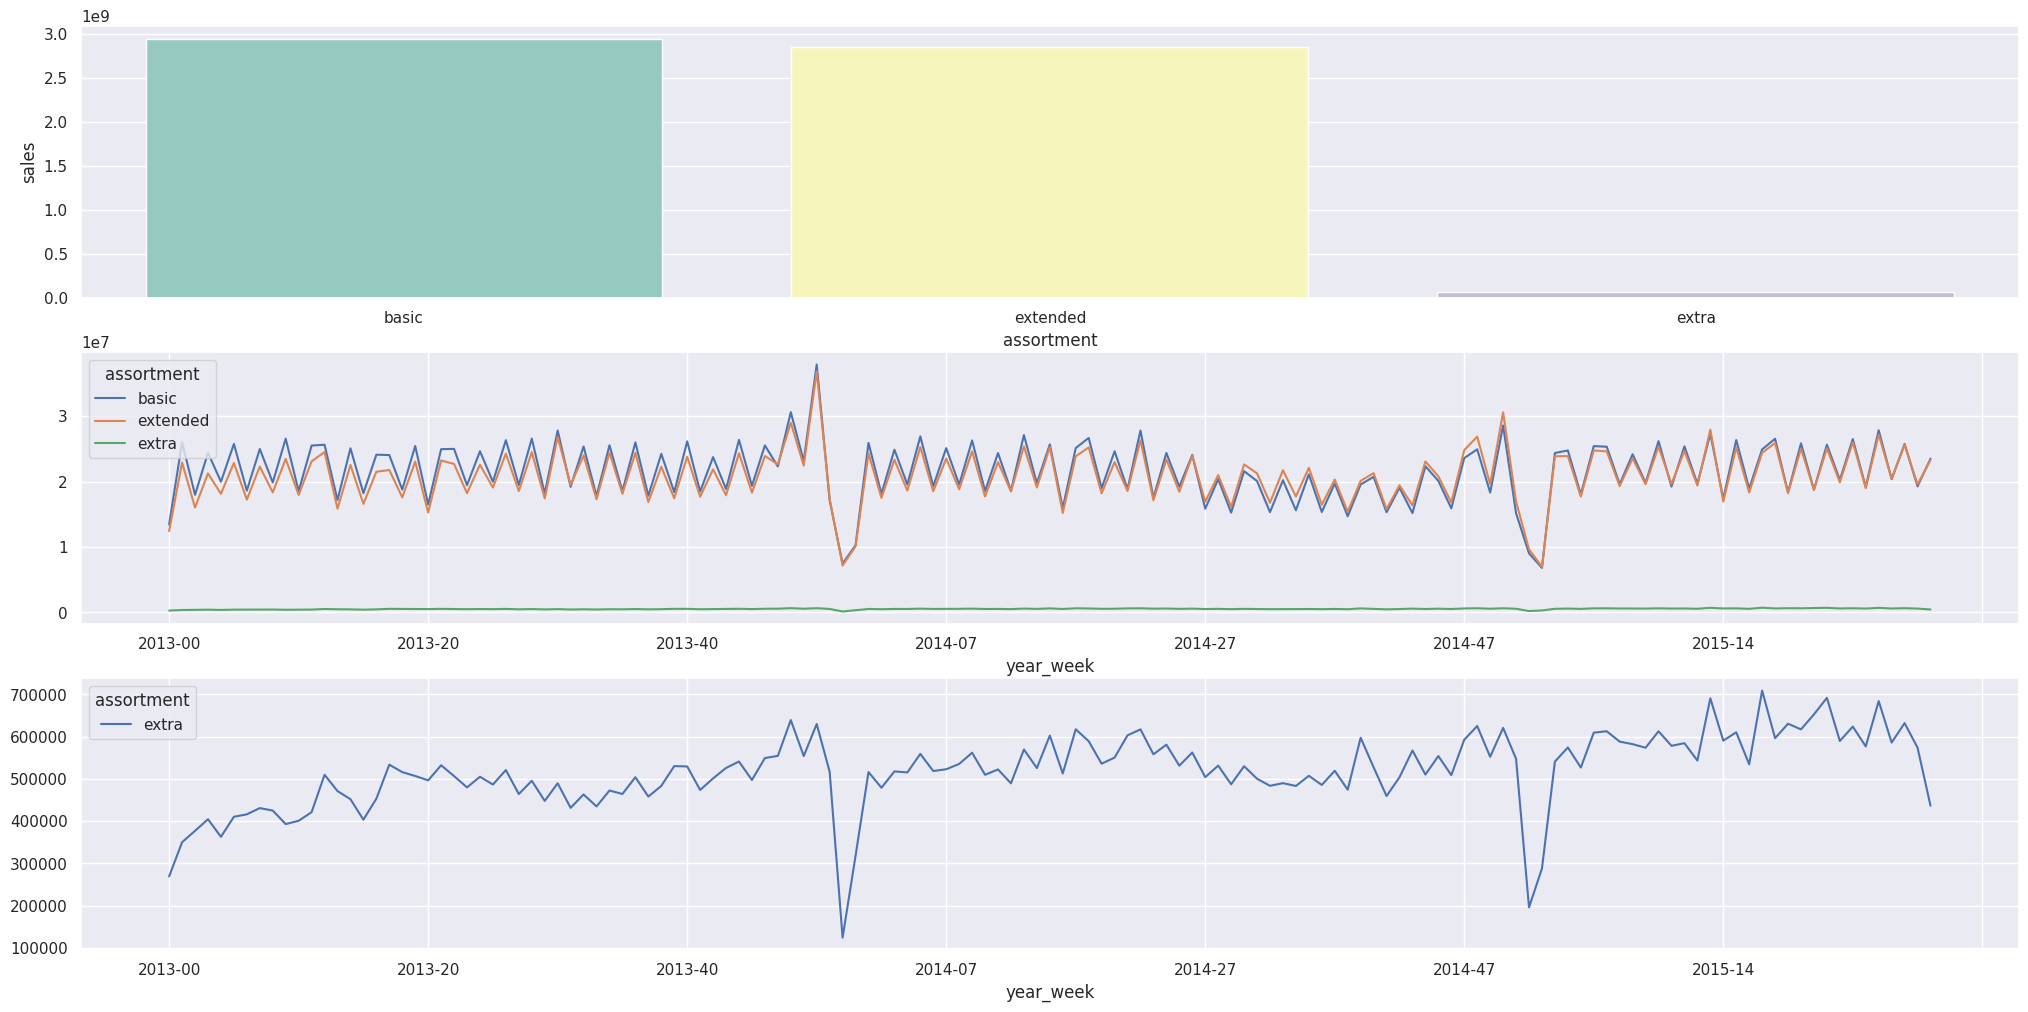

In [40]:
fig, axs = plt.subplots( 3, 1, sharex=False )

aux_h1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( data=aux_h1, x='assortment', y='sales', hue='assortment', palette='Set3', ax=axs[0] )

aux2_h1 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2_h1.pivot( index='year_week', columns='assortment', values='sales' ).plot(ax=axs[1]);

aux3_h1 = aux2_h1[aux2_h1['assortment'] == 'extra']
aux3_h1.pivot( index='year_week', columns='assortment', values='sales' ).plot(ax=axs[2]);

### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

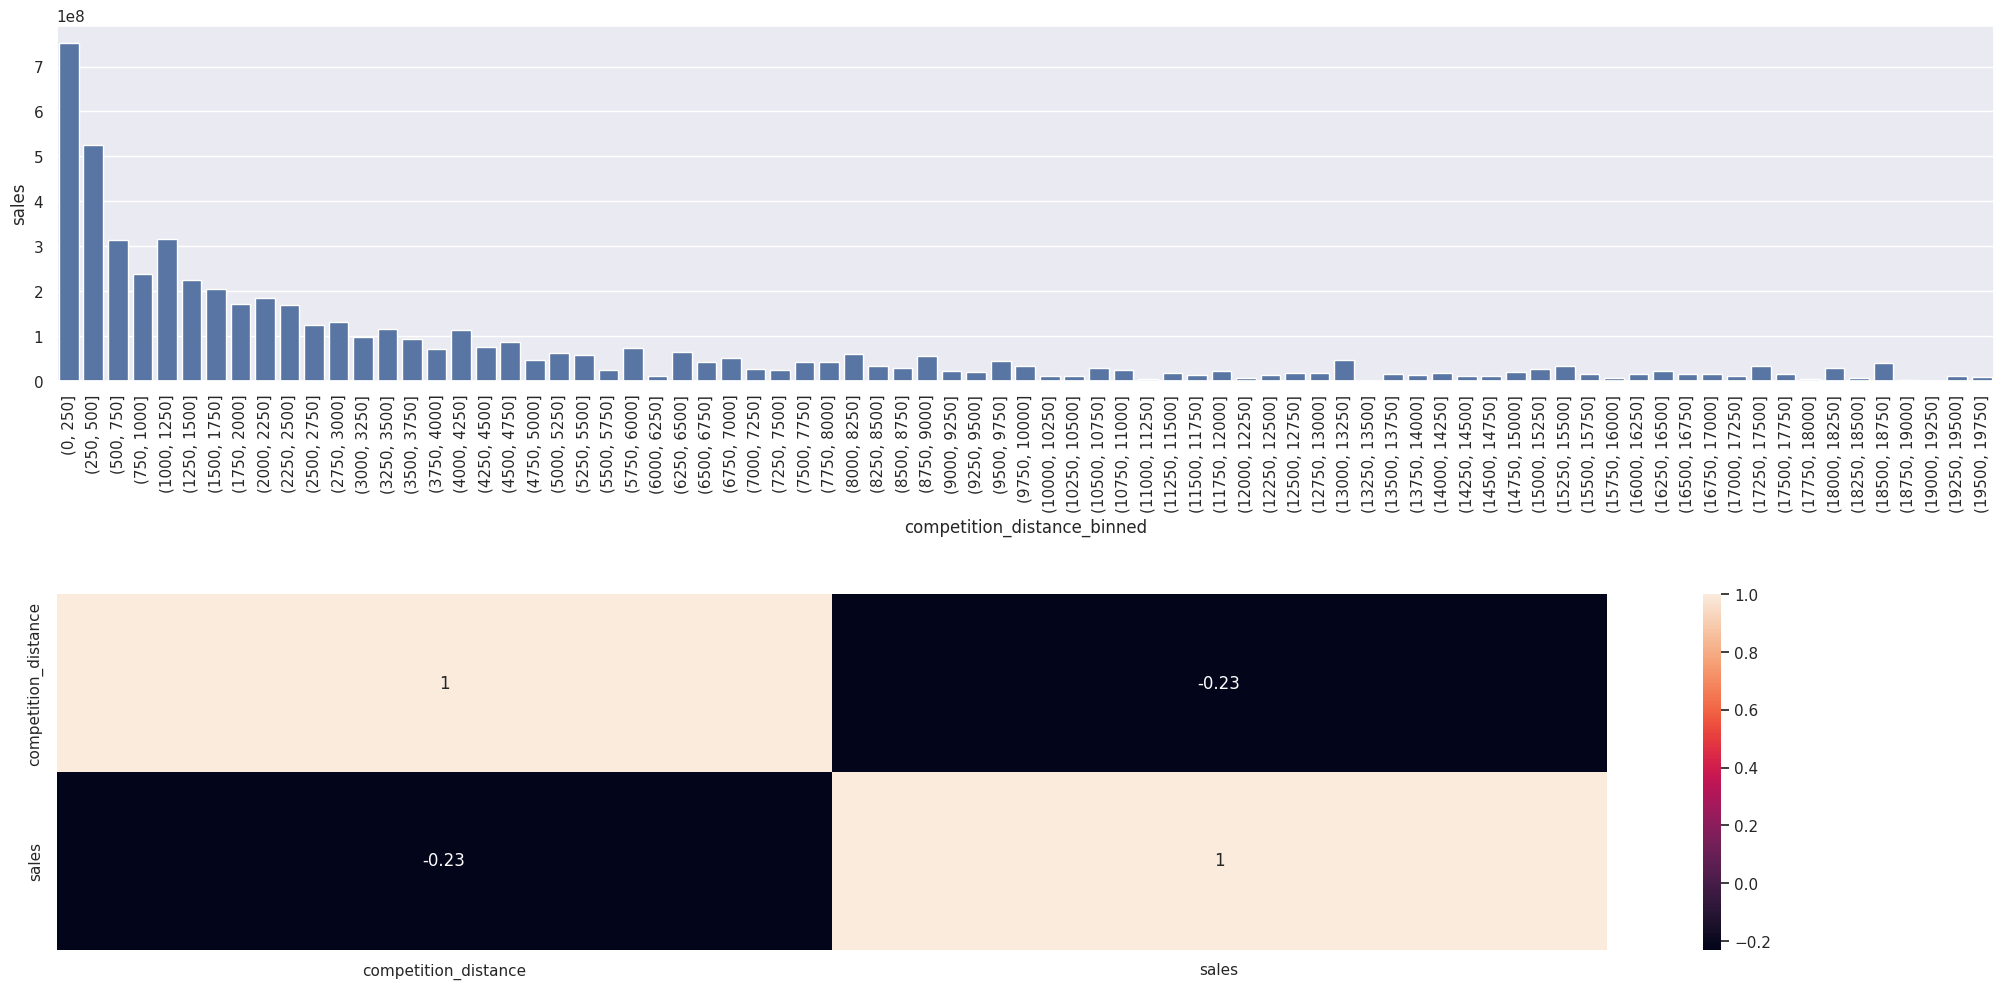

In [41]:
df_aux = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = list( np.arange( 0, 20000, 250 ) )
df_aux['competition_distance_binned'] = pd.cut( df_aux['competition_distance'], bins=bins )
aux = df_aux[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned', observed=False ).sum().reset_index()

fig, axs = plt.subplots(2, 1, sharex=False)

axs[0].tick_params(axis='x', rotation=90)
sns.barplot( x='competition_distance_binned', y='sales', data=aux, ax=axs[0]);

sns.heatmap( df_aux[['competition_distance', 'sales']].corr( method='pearson' ), annot=True, ax=axs[1] );

fig.subplots_adjust(hspace=0.6)

### H3. Lojas com competidores à mais tempo deveriam vender mais.

**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem menos.

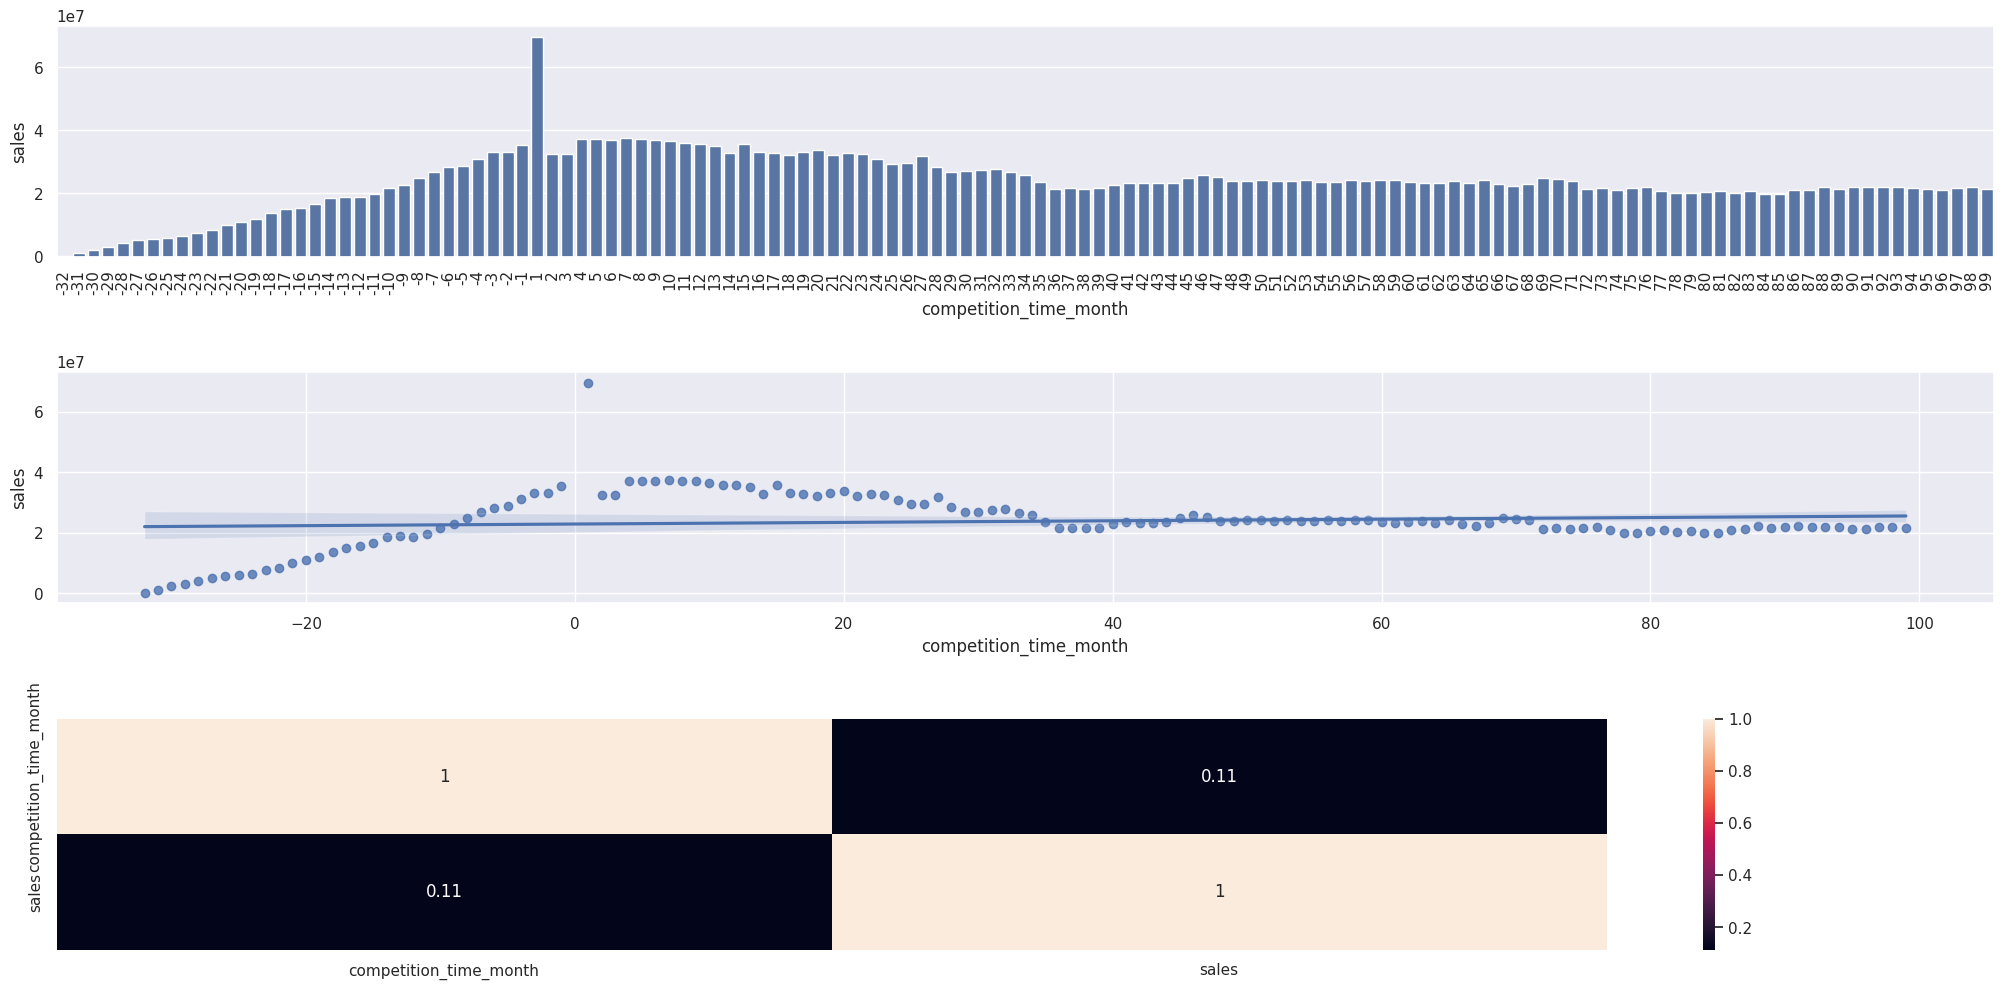

In [42]:
fig, axs = plt.subplots( 3, 1, sharex=False )


df_aux = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
df_aux2 = df_aux[ ( df_aux['competition_time_month'] < 100 ) & ( df_aux['competition_time_month'] != 0 ) ]
sns.barplot( data=df_aux2, x='competition_time_month', y='sales', ax=axs[0]);
axs[0].tick_params( 'x', rotation=90 )

sns.regplot( x='competition_time_month', y='sales', data=df_aux2, ax=axs[1] );

sns.heatmap( df_aux2.corr( method='pearson' ), annot=True, ax=axs[2]);

fig.subplots_adjust(hspace=0.5)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

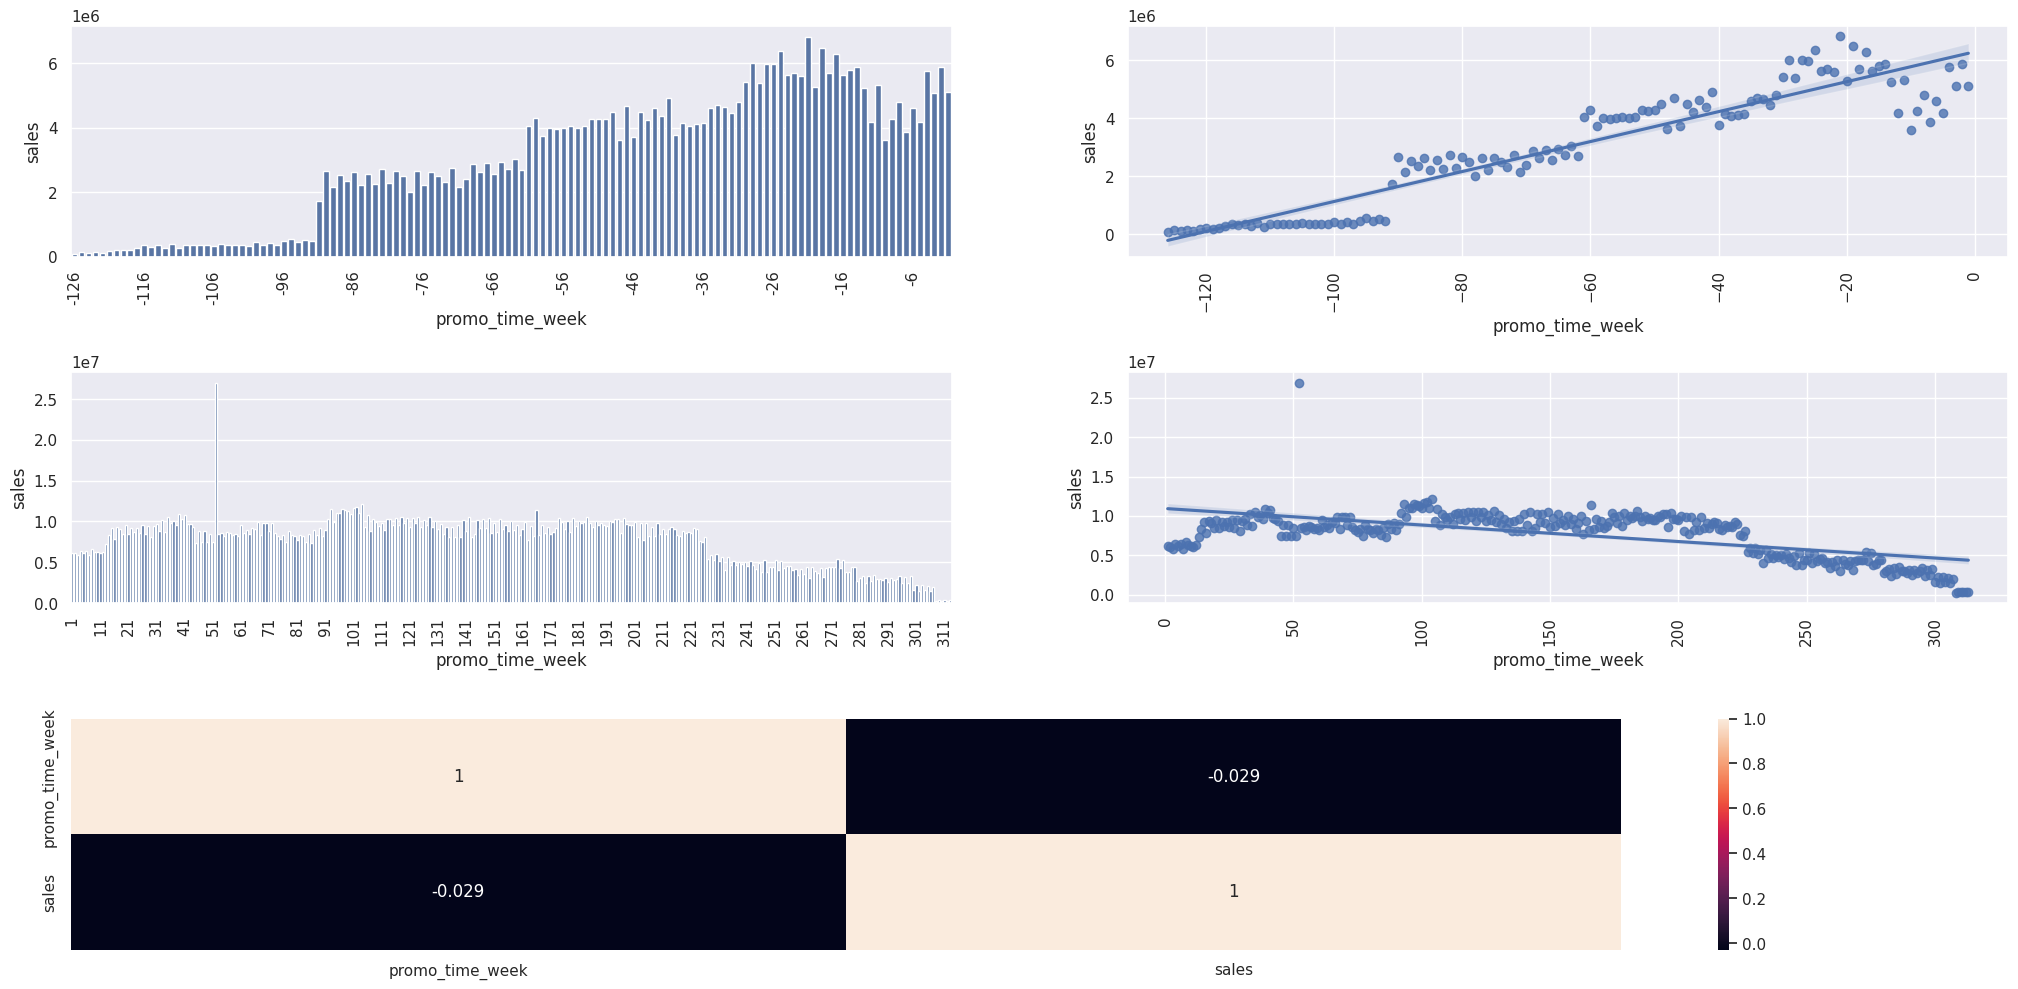

In [43]:
df_aux = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = plt.GridSpec( 3, 2, hspace=0.5 )

aux_regular = df_aux[( df_aux['promo_time_week'] < 0 )]
aux_extendida = df_aux[( df_aux['promo_time_week'] > 0 ) ]

fig = plt.figure()


ax1 = fig.add_subplot( grid[0, 0] )
sns.barplot( data=aux_regular, x='promo_time_week', y='sales', ax=ax1 );
ticks_loc = ax1.get_xticks()[::10]
ticks_labels = [label.get_text() for label in ax1.get_xticklabels()][::10]
ax1.set_xticks(ticks_loc)
ax1.set_xticklabels(ticks_labels, rotation=90)

ax2 = fig.add_subplot( grid[0, 1] )
sns.regplot( data=aux_regular, x='promo_time_week', y='sales', ax=ax2 );
ax2.tick_params('x', rotation=90)

ax3 = fig.add_subplot( grid[1, 0] )
sns.barplot( data=aux_extendida, x='promo_time_week', y='sales', ax=ax3 );
ticks_loc = ax3.get_xticks()[::10]
ticks_labels = [label.get_text() for label in ax3.get_xticklabels()][::10]
ax3.set_xticks(ticks_loc)
ax3.set_xticklabels(ticks_labels, rotation=90)

ax4 = fig.add_subplot( grid[1, 1] )
sns.regplot( data=aux_extendida, x='promo_time_week', y='sales', ax=ax4 );
ax4.tick_params('x', rotation=90)

ax4 = fig.add_subplot( grid[2, :] )
sns.heatmap( df_aux.corr( method='pearson' ), annot=True );


### H5. Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

In [44]:
aux = df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().sort_values('sales', ascending=False).reset_index()

conditions = [
    (aux['promo'] == 0) & (aux['promo2'] == 0),
    (aux['promo'] == 0) & (aux['promo2'] == 1),
    (aux['promo'] == 1) & (aux['promo2'] == 0),
    (aux['promo'] == 1) & (aux['promo2'] == 1)
]

values = ["Sem promoção", "Extendida", "Tradicional", "Tradicional e Extendida"]

aux['legenda'] = np.select(conditions, values)

aux

,promo,promo2,sales,legenda
0,1,0,1628930532,Tradicional
1,0,0,1482612096,Sem promoção
2,1,1,1472275754,Tradicional e Extendida
3,0,1,1289362241,Extendida


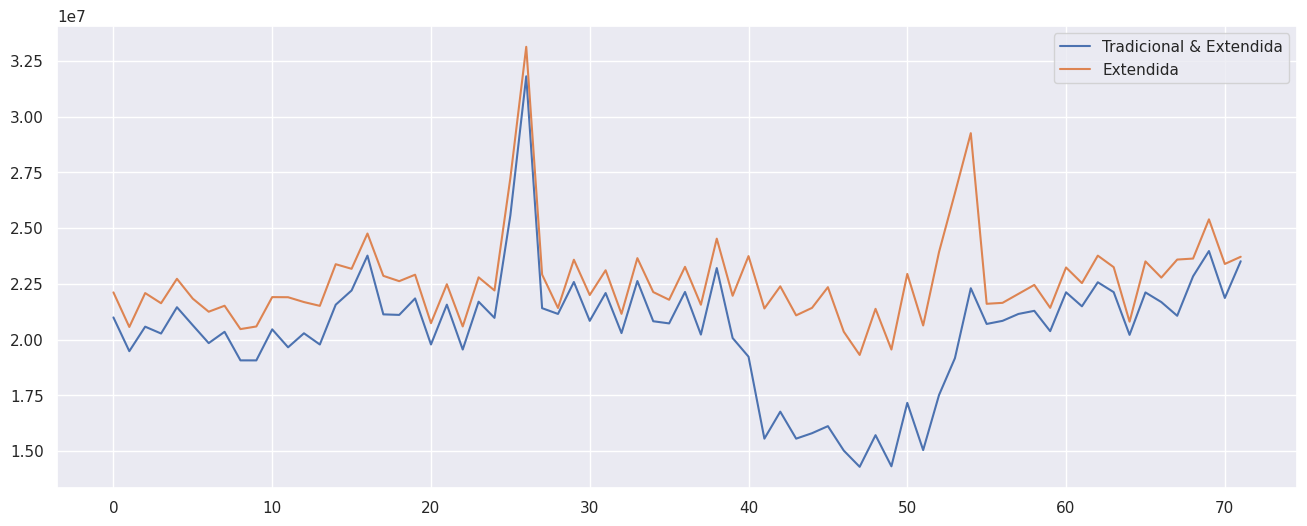

In [45]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot( figsize=(16,6))

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida'] );

### H6. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** Lojas abertas durante o feriado de Natal vendem menos

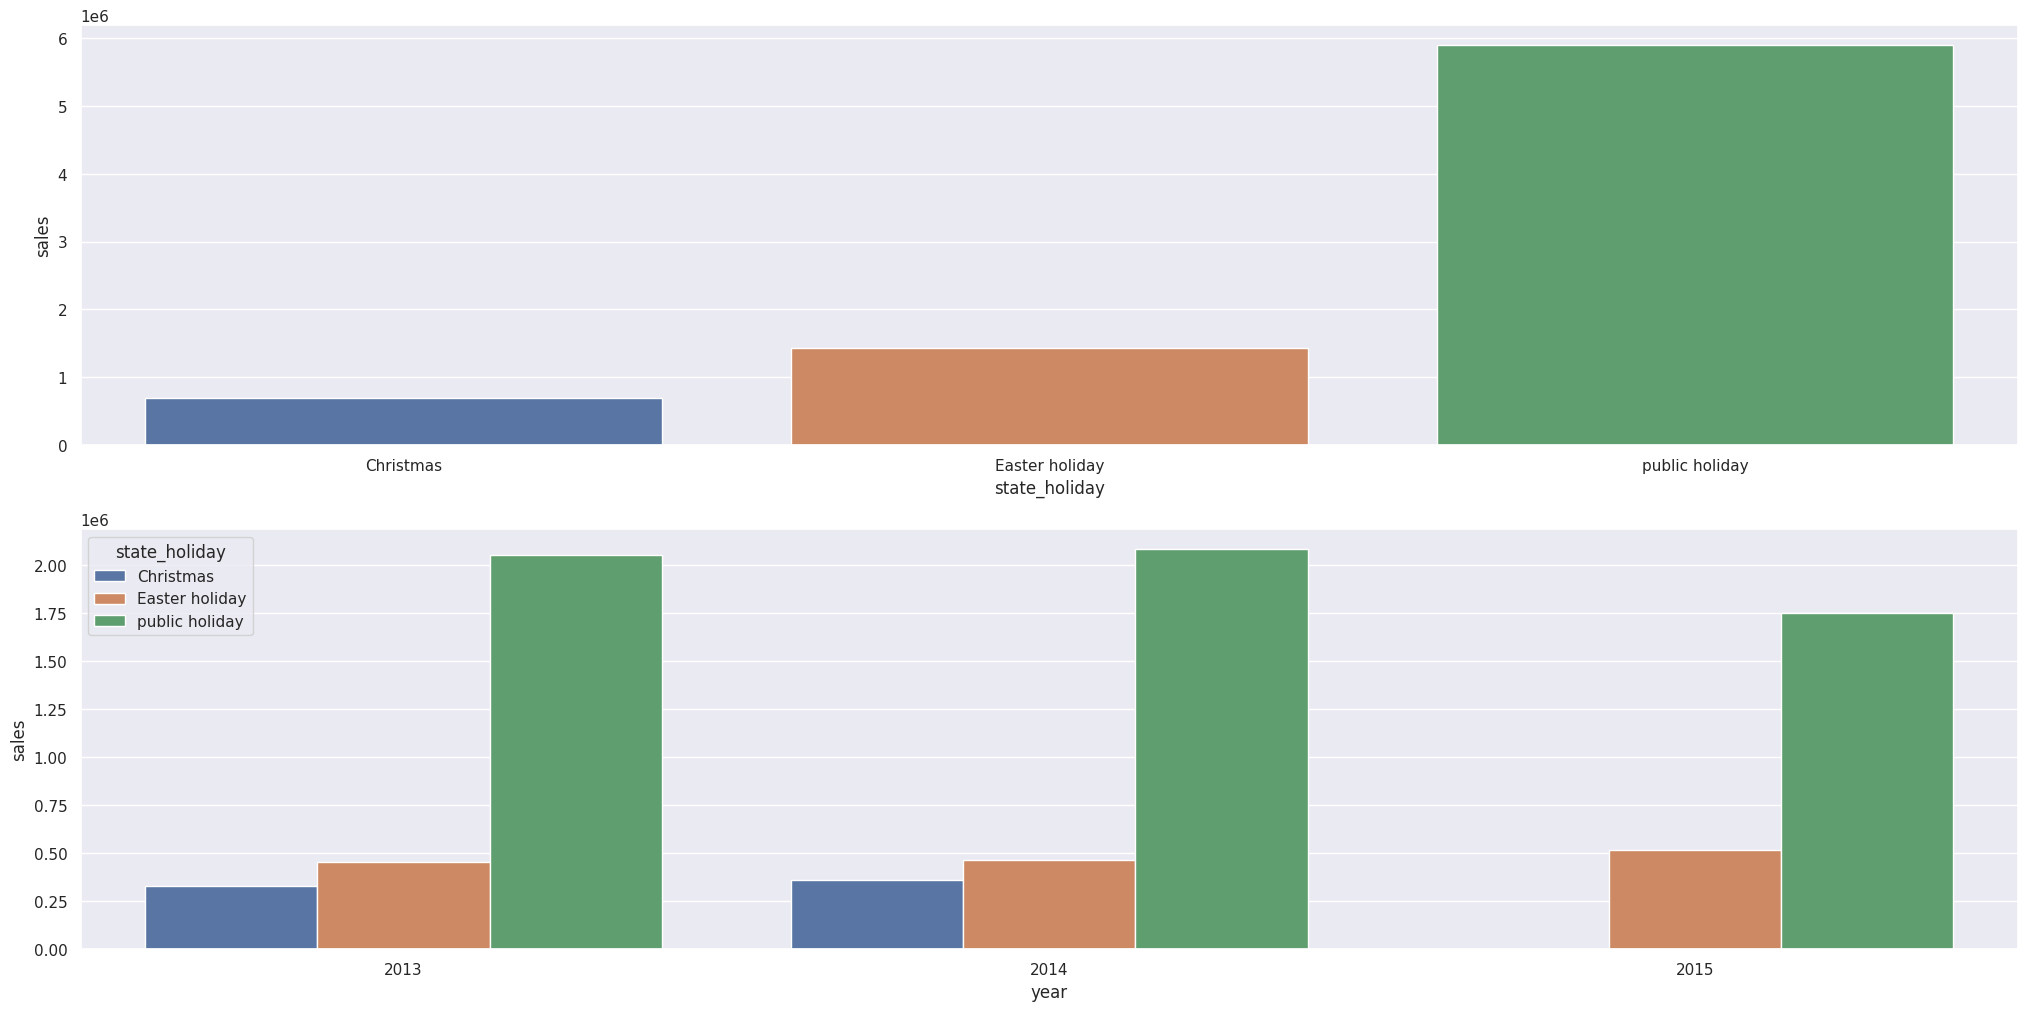

<Figure size 1600x500 with 0 Axes>

In [46]:
aux = df4[df4['state_holiday'] != 'regular_day']

df_aux = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()

fig, axs = plt.subplots( 2, 1, sharex=False )

plt.figure( figsize=(16,5));
sns.barplot( data=df_aux, x='state_holiday', y='sales', hue='state_holiday', ax=axs[0] );

aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( data=aux2, x='year', y='sales', hue='state_holiday', ax=axs[1] );

### H7. Lojas deveriam vender mais ao longo dos anos.

**FALSA** Lojas vendem menos ao longo do ano. Mesmo que 2015 não seja um ano fechado, percebe-se uma tendência de queda.

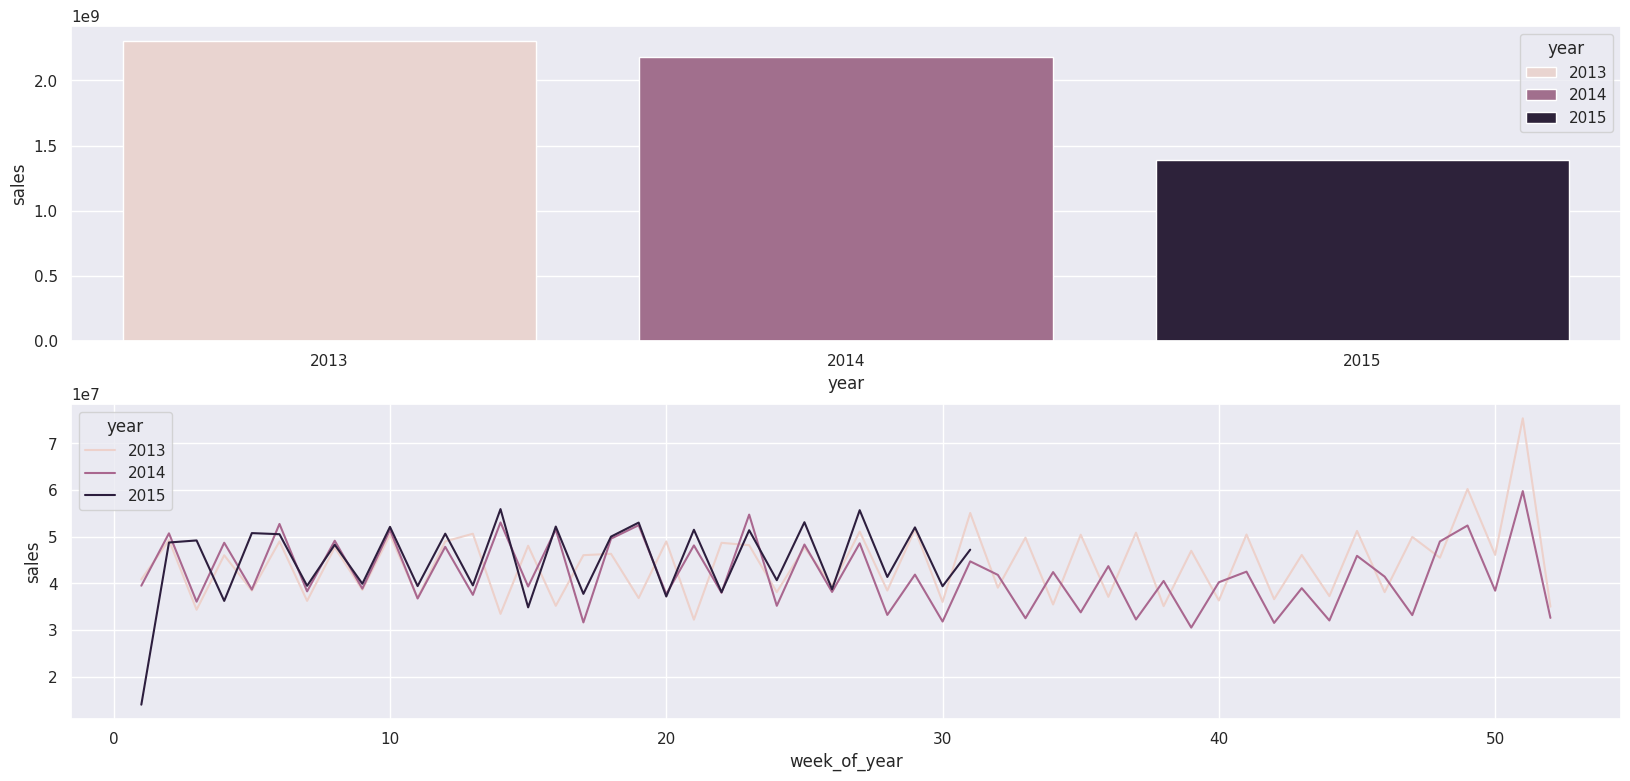

In [47]:
aux = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index().sort_values('sales', ascending=False)


fig, axs = plt.subplots( 2, 1, sharex=False, figsize=(20,9) )

sns.barplot( data=aux, x='year', y='sales', hue='year', ax=axs[0])

aux2 = df4[['week_of_year', 'sales', 'year']].groupby( ['week_of_year', 'year'] ).sum().reset_index()

sns.lineplot( data=aux2, x='week_of_year', y='sales', hue='year', ax=axs[1] );

##! Adicionar o gráfico de regressão (regplot) e de correlação. Colocar os dois em uma única linha na imagem

### H8. Lojas deveriam vender mais no segundo semestre do ano.

**FALSA** Lojas vendem menos no segundo semestre do ano

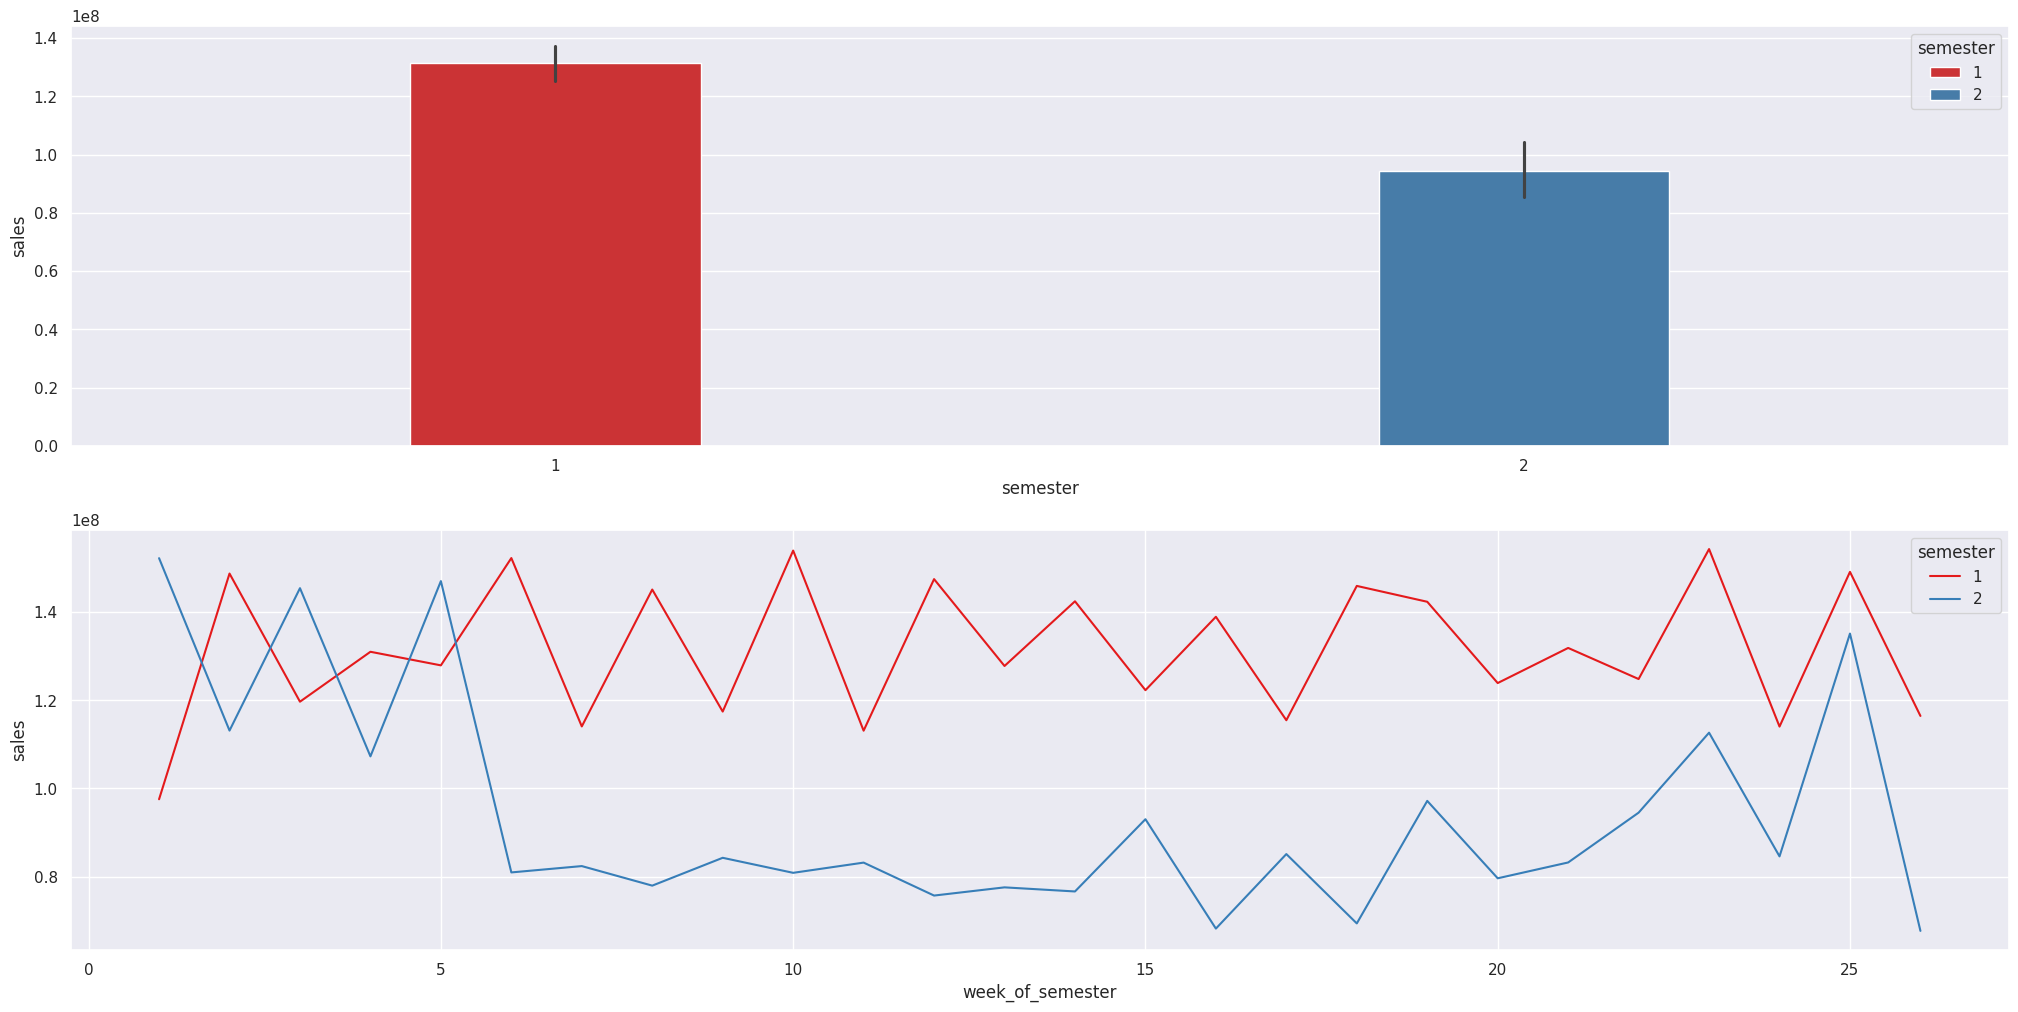

In [48]:
df_aux = df4[df4['year'] != '2015']

df_aux['semester'] = df_aux.apply( lambda x: 1 if x['month'] <= 6 else 2, axis=1)
df_aux['week_of_semester'] = df_aux['week_of_year'].apply(lambda x: x if x <= 26 else x - 26)

fig, axs = plt.subplots( 2, 1, sharex=False)

aux = df_aux[['semester', 'sales', 'week_of_semester']].groupby( ['semester', 'week_of_semester'] ).sum().reset_index()
sns.barplot( data=aux, x='semester', y='sales', hue='semester', ax=axs[0], width=0.3, palette='Set1' );

sns.lineplot( data=aux, x='week_of_semester', y='sales', hue='semester', ax=axs[1], palette='Set1' );

### H9. Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

<Axes: xlabel='before_after', ylabel='sales'>

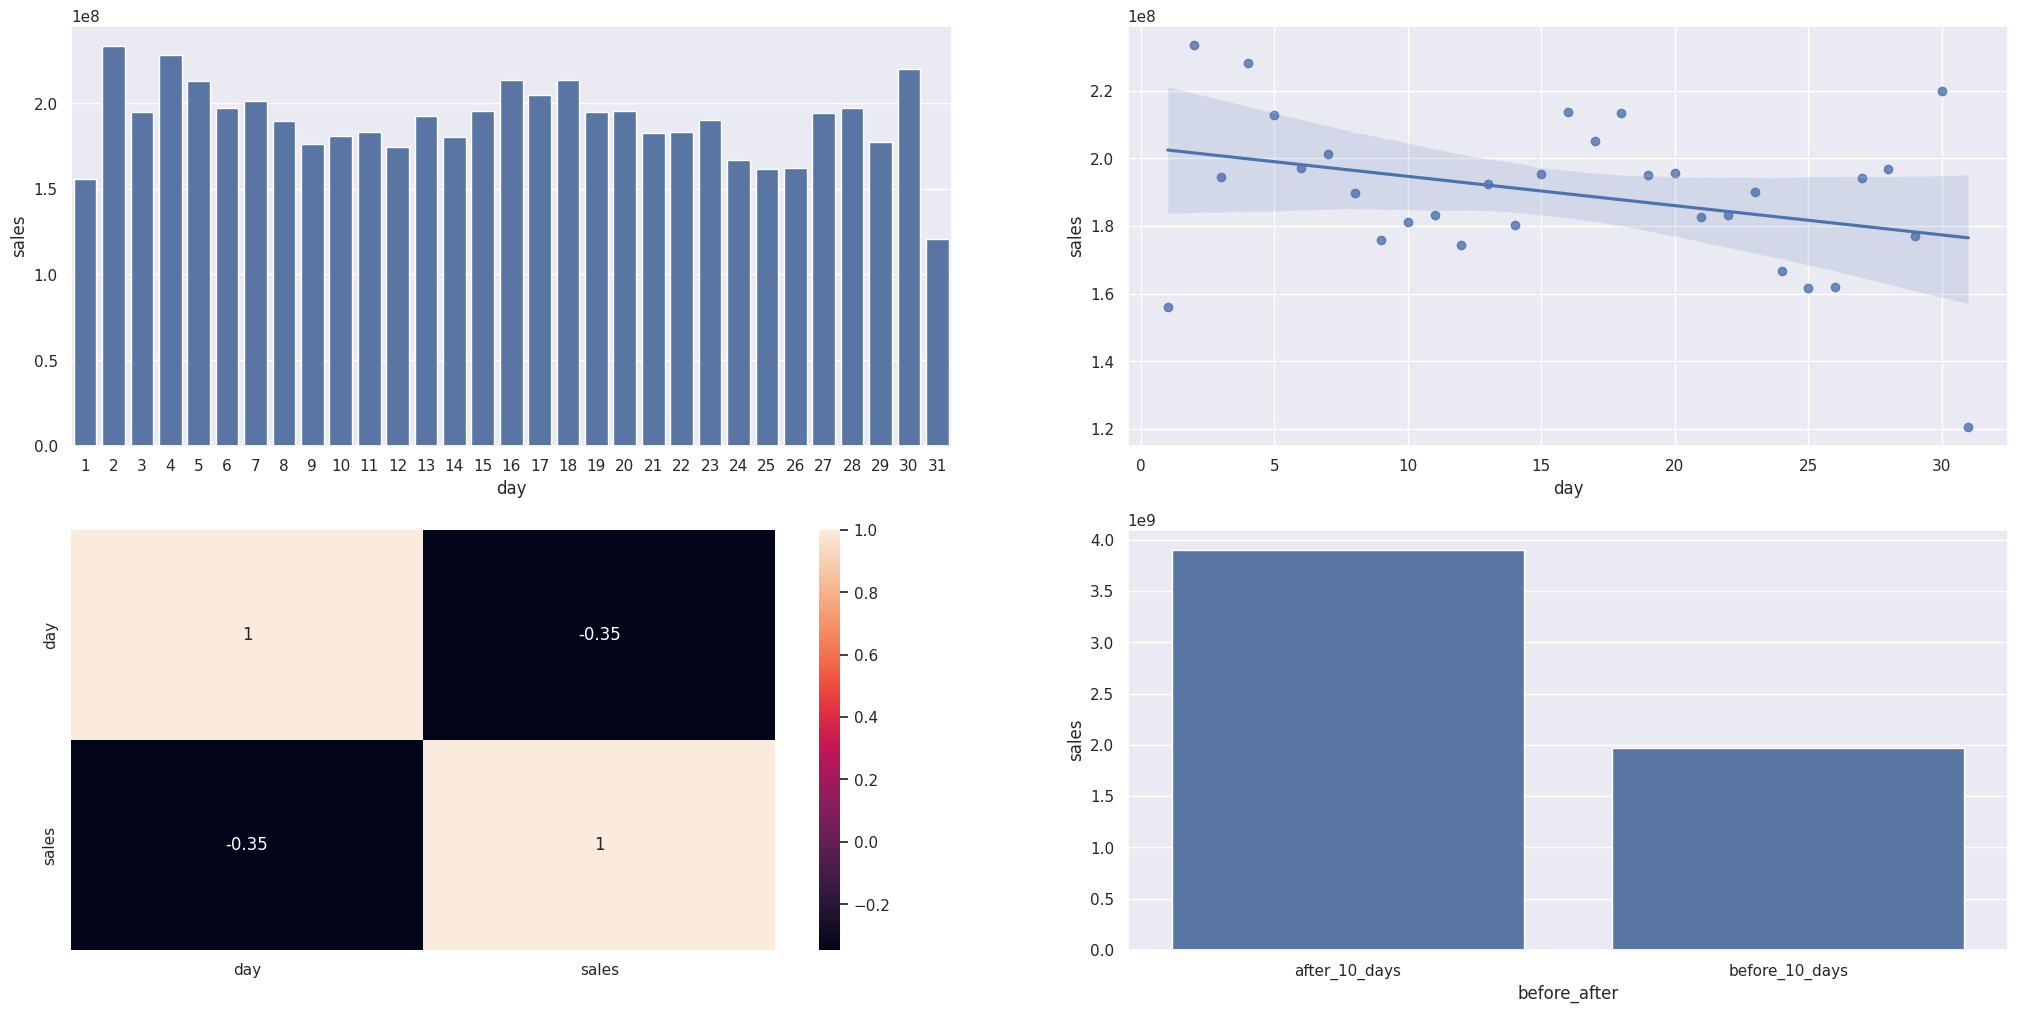

In [49]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

fig, axs = plt.subplots( 2, 2, sharex=False)

sns.barplot( data=aux1, x='day', y='sales', ax=axs[0, 0] );

sns.regplot( data=aux1, x='day', y='sales', ax=axs[0, 1] );

sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axs[1, 0] );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

sns.barplot( data=aux2, x='before_after', y='sales', ax=axs[1, 1] )


### H10. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos nos finais de semana.

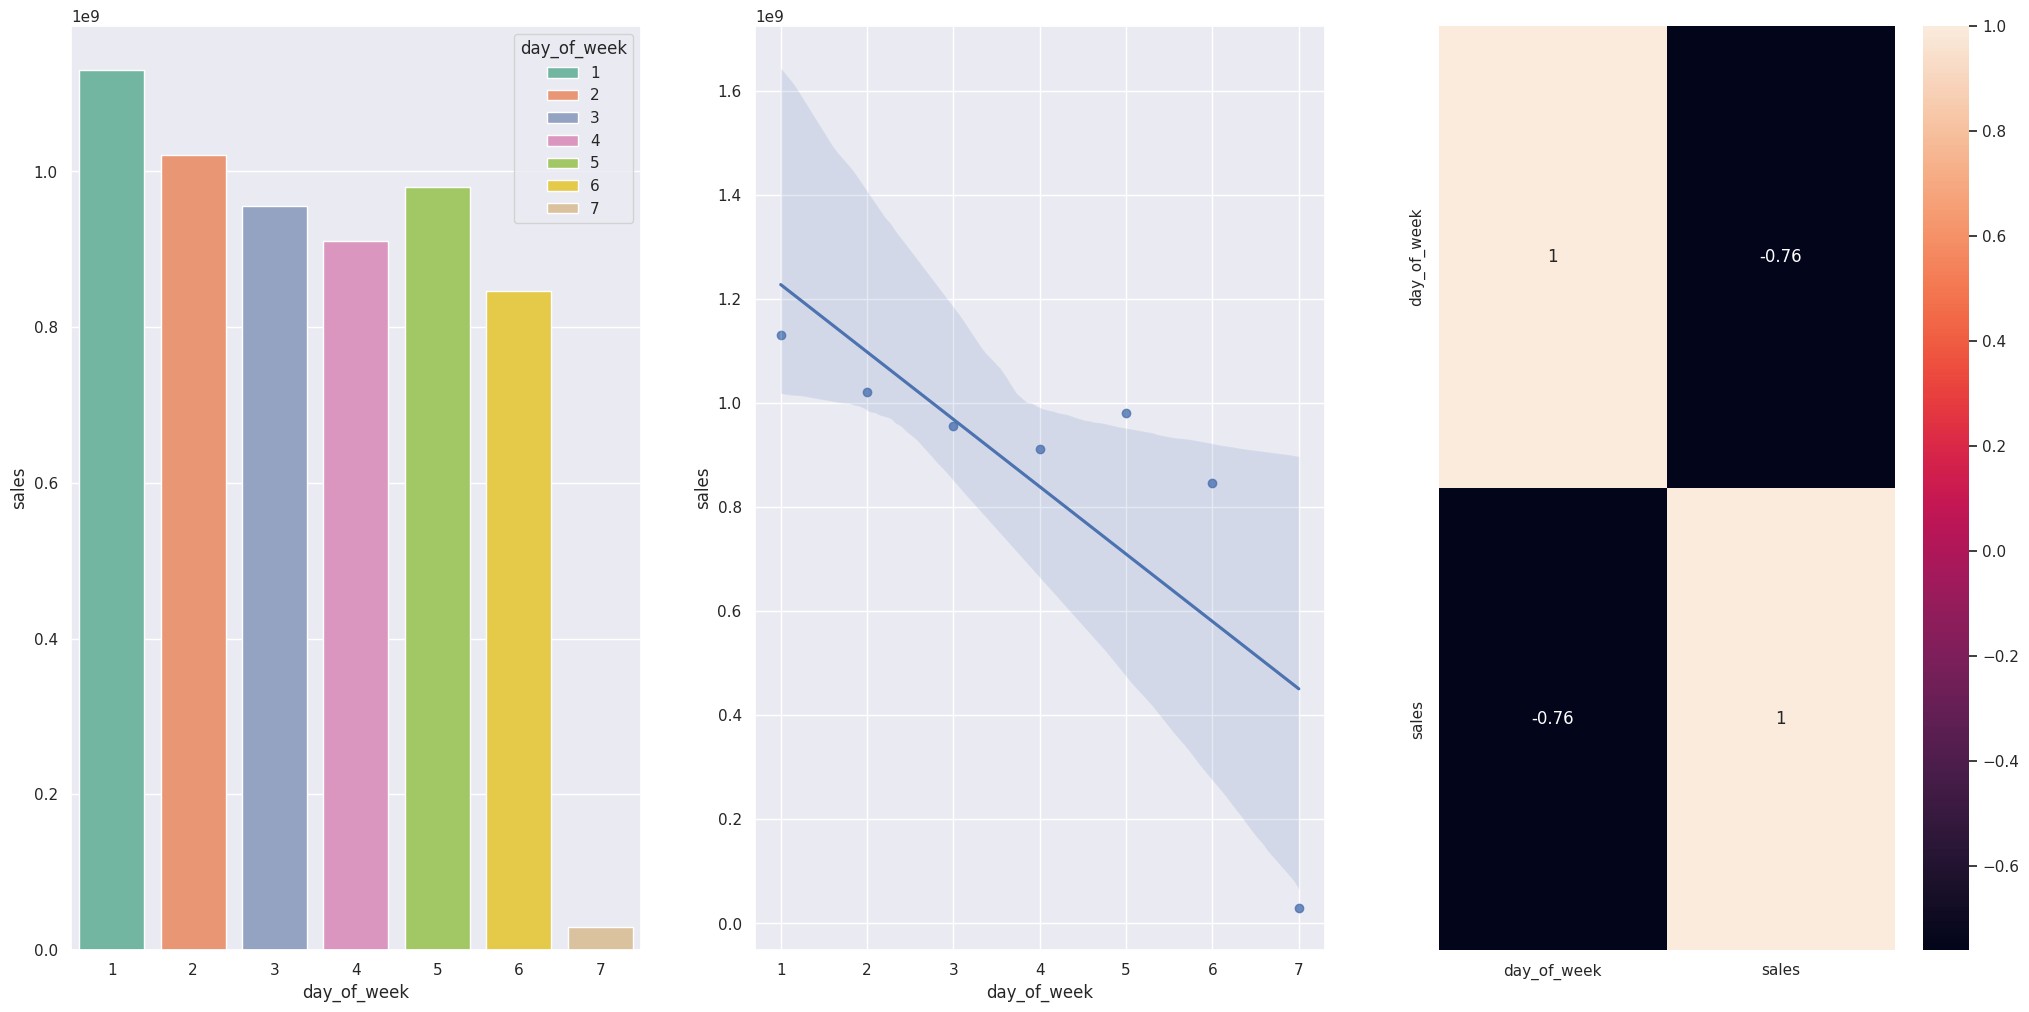

In [50]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

fig, axs = plt.subplots( 1, 3)

sns.barplot( data=aux1, x='day_of_week', y='sales', hue='day_of_week', palette='Set2', ax=axs[0] )

sns.regplot( data=aux1, x='day_of_week', y='sales', ax=axs[1] )

sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axs[2] );

### H11. Lojas deveriam vender menos durante feriados escolares.

**VERDADEIRA** Loja vendem menos durante os feriados escolares, exceto durante os meses de Julho e Agosto.

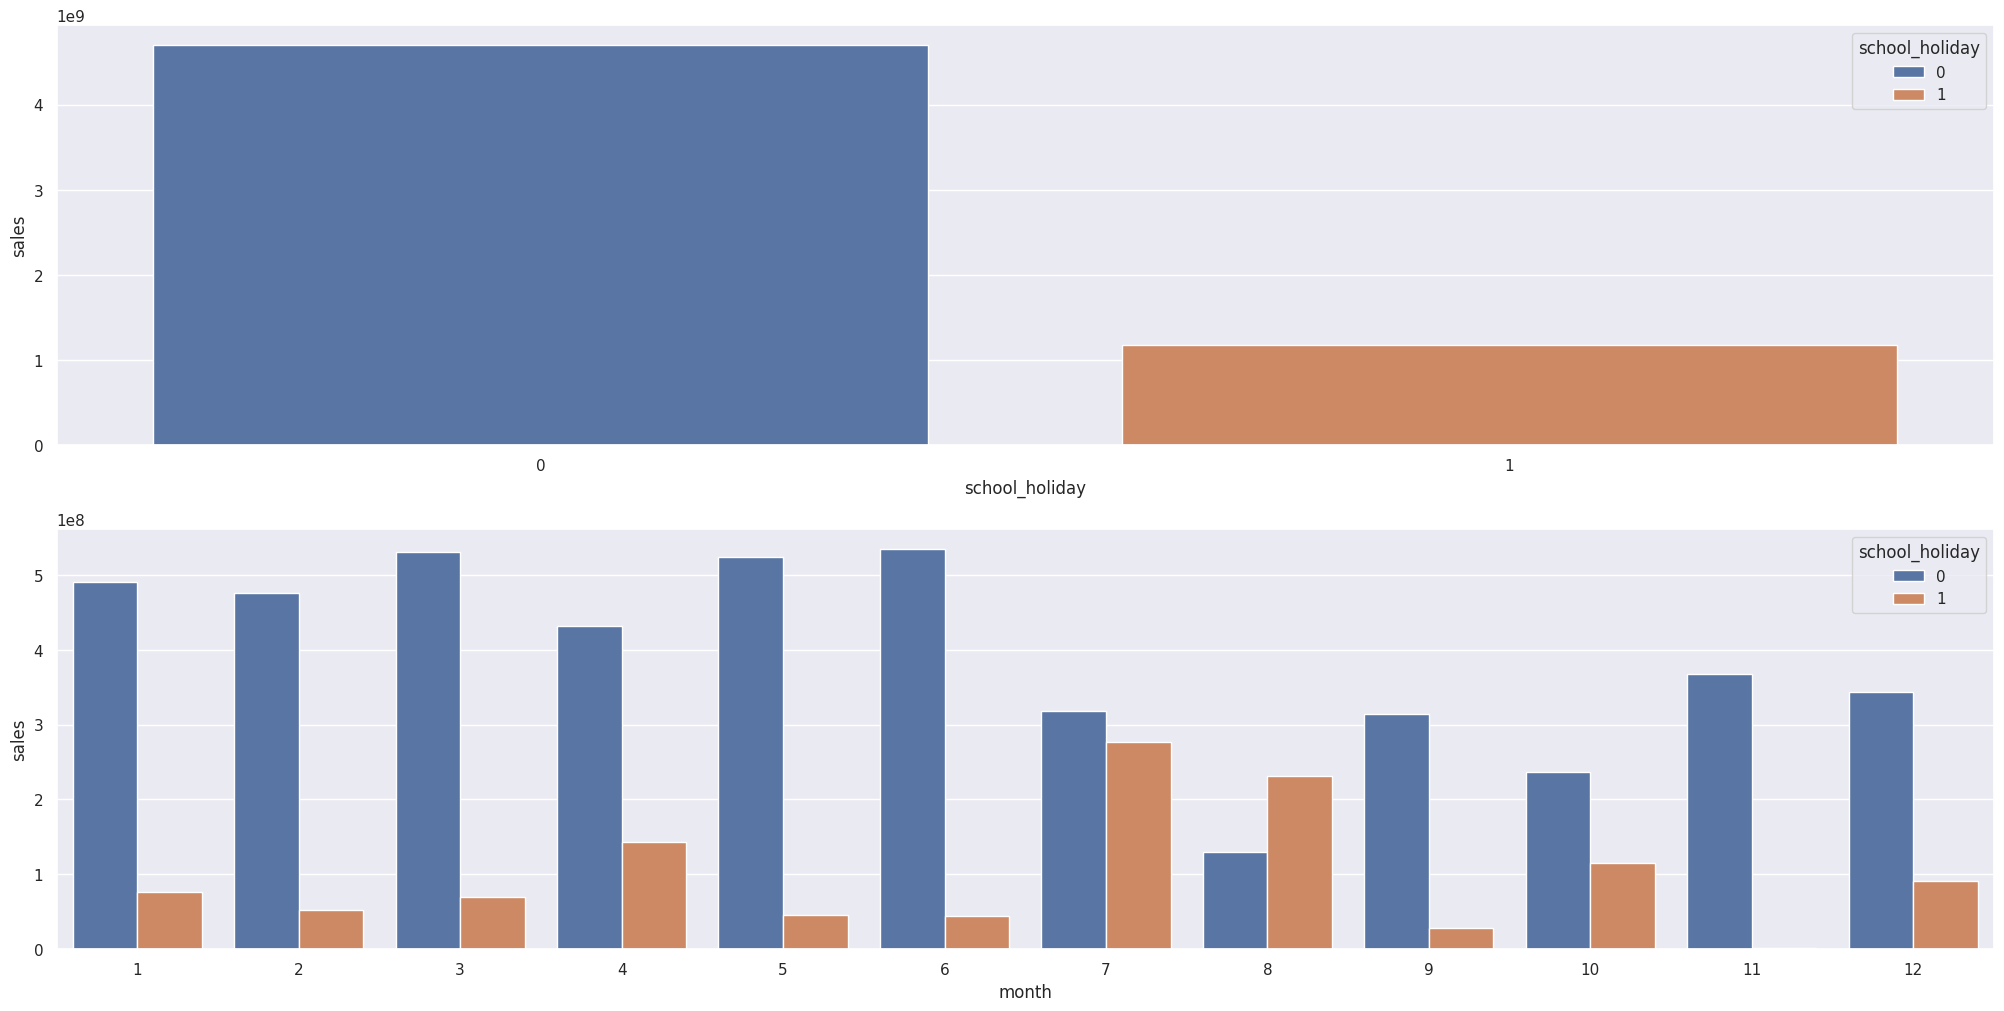

In [51]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

fig, axs = plt.subplots( 2, 1 )

sns.barplot( data=aux1, x='school_holiday', y='sales', hue='school_holiday', ax=axs[0] );

aux2 = df4[[ 'month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

sns.barplot( data=aux2, x='month', y='sales', hue='school_holiday', ax=axs[1] );

### 4.2.1. Resumo das Hipóteses

In [52]:
tab = [
    ['Hipóteses', 'Conclusão', 'Relevância'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Média'],
    ['H3', 'Falsa', 'Média'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', 'Falsa', 'Baixa'],
    ['H6', 'Falsa', 'Média'],
    ['H7', 'Falsa', 'Alta'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Verdadeira', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Baixa']]

In [53]:
print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           Falsa        Baixa
H6           Falsa        Média
H7           Falsa        Alta
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Verdadeira   Alta
H11          Verdadeira   Baixa


In [54]:
del aux, aux2_h1, aux3_h1, aux_extendida, aux_h1, aux_regular, ax, ax1, ax2, ax3, ax4, axs, bins, cols_drop

In [55]:
del df_aux, df_aux2, fig, grid, m, num_attributes, state_holiday_map, ticks_labels, ticks_loc, values

## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

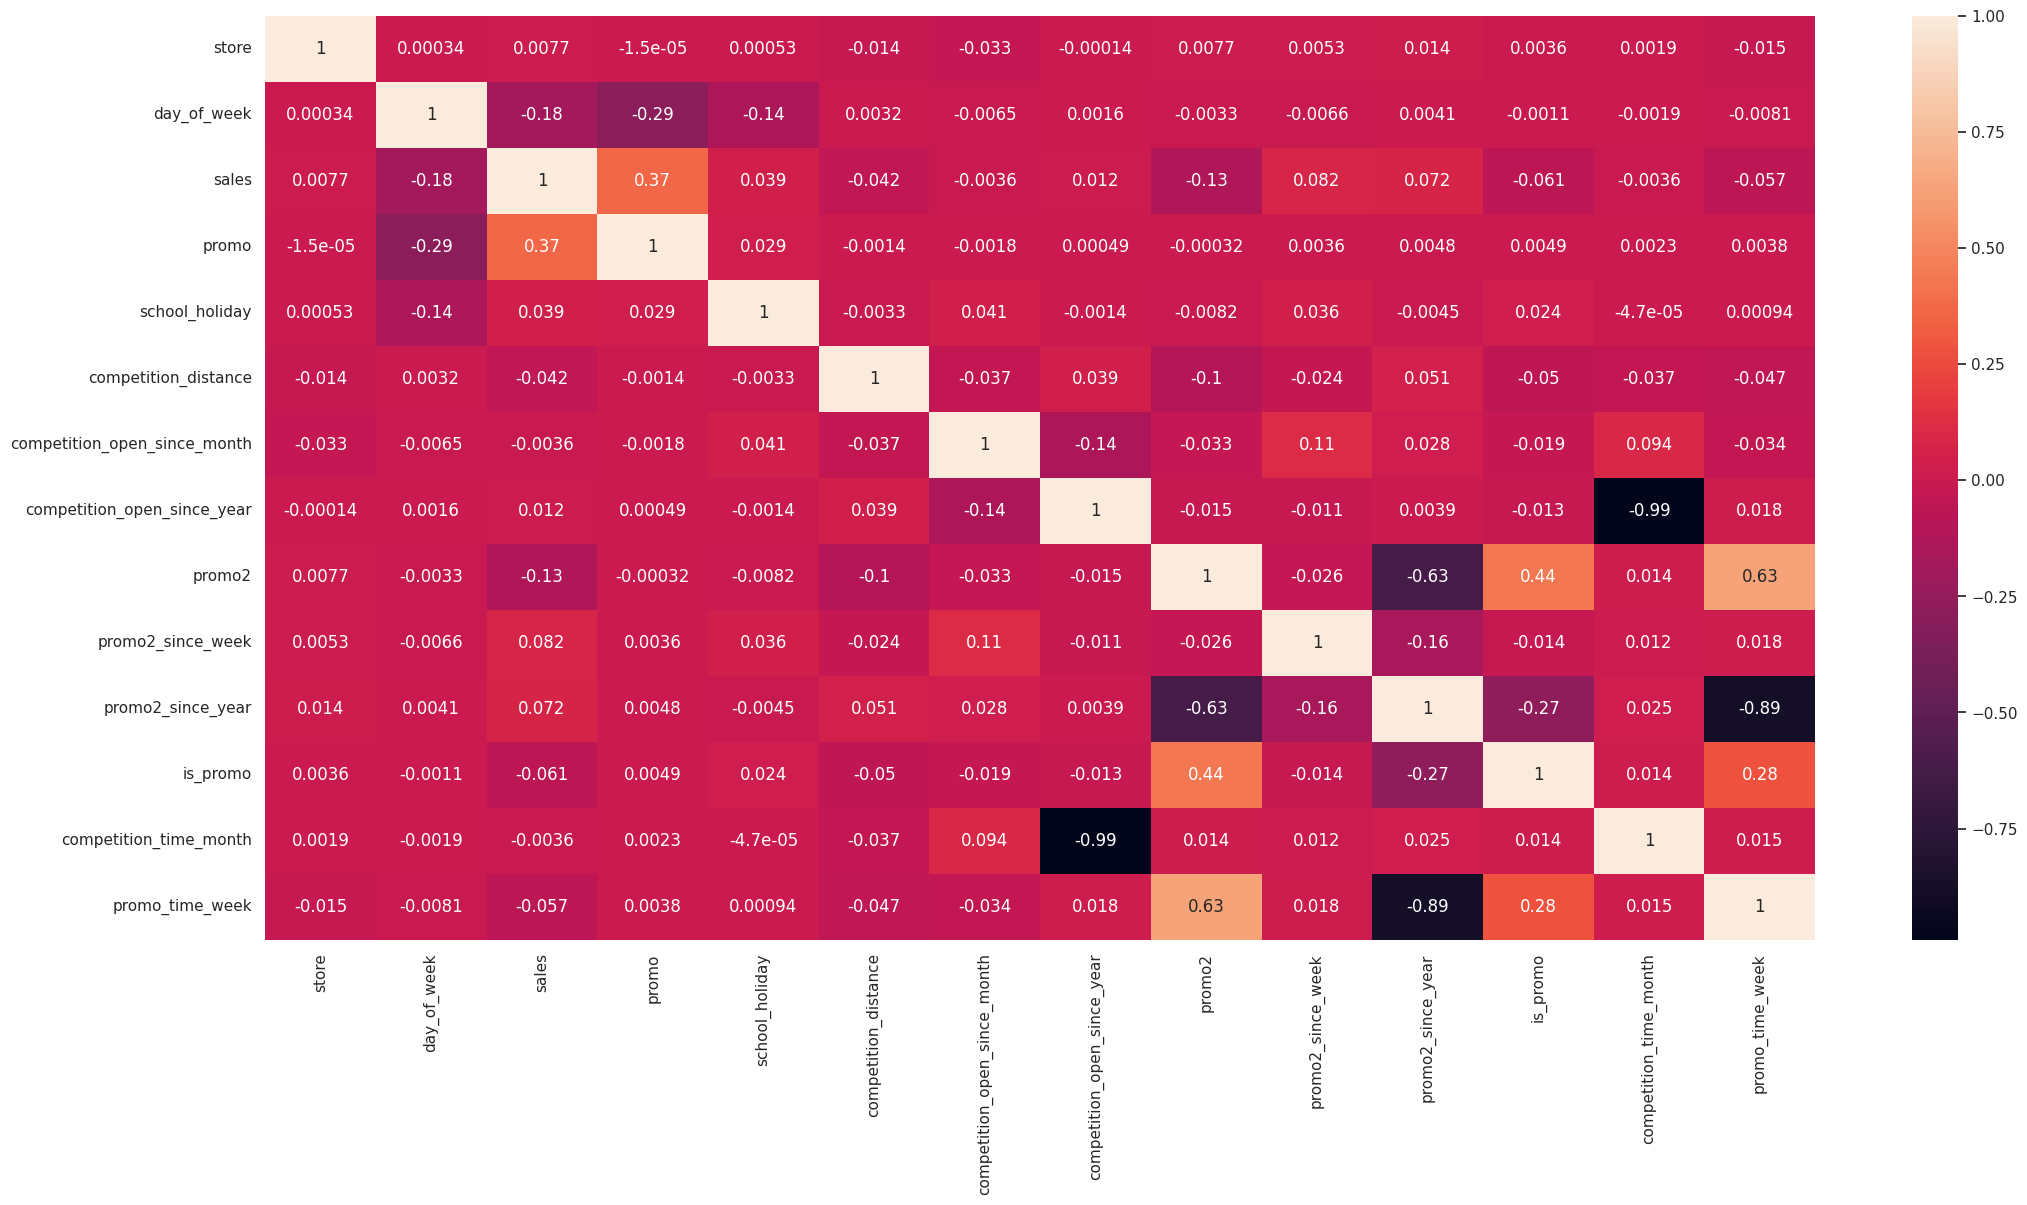

In [56]:
num_attributes = df4.select_dtypes( include=['int64', 'float64'] )
correlation = num_attributes.corr( method='pearson' )

sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [57]:
a = df4.select_dtypes( include='object' )

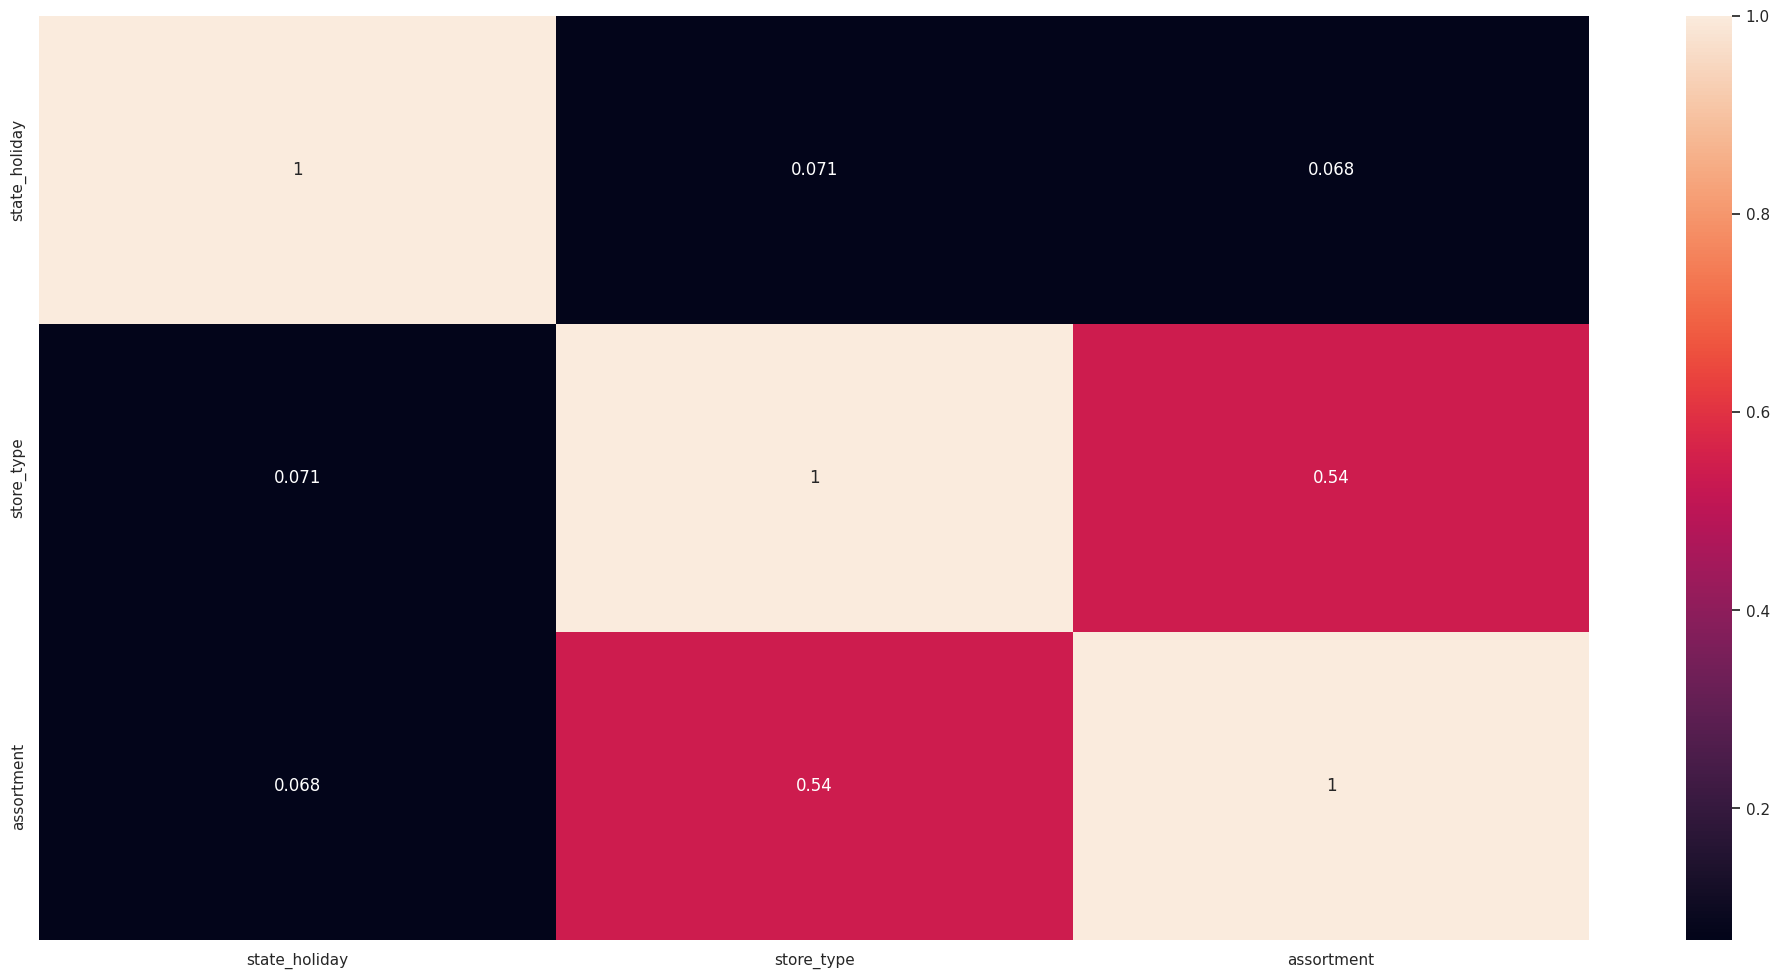

In [58]:
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]})

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

In [59]:
del a, a1, a2, a3, a4, a5, a6, a7, a8, a9, assortment_map, aux1, aux2, correlation, d, num_attributes

# 5.0. PREPARAÇÃO DOS DADOS

In [60]:
df5 = df4.copy()
del df3

## 5.1. Normalização

## 5.2. Rescaling

In [61]:
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( '../parameter/scaler_competition_distance.pkl', 'wb' ) )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( '../parameter/scaler_competition_time_month.pkl', 'wb' ) )

# promo time week
df5['promo_time_week'] = rs.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( '../parameter/scaler_promo_time_week.pkl', 'wb' ) )

df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '../parameter/scaler_year.pkl', 'wb' ) )

## 5.3. Transformação

### 5.3.1. Encoding

In [62]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int )

# store_type - Label Encoding
le = pp.LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( '../parameter/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Reponse Variable Transformation

In [63]:
df5['sales'] = np.log1p( df4['sales'] )

### 5.3.3. Nature Transformation

In [64]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [65]:
del assortment_dict

# 6.0. FEATURE SELECTION

In [66]:
df6 = df5.copy()
del df4

## 6.1. Split dataframe into training and test dataset

In [67]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [68]:
max_dates = df6[['store', 'date']].groupby( 'store' ).max().reset_index()
min_dates = df6[['store', 'date']].groupby( 'store' ).min().reset_index()

min_dates.rename(columns={'date': 'min_date'}, inplace=True)
max_dates.rename(columns={'date': 'max_date'}, inplace=True)

aux = pd.merge(min_dates, max_dates, on='store')

max_date = aux.max_date.max()
min_date = aux.min_date.min()

print( 'Data Inicial de Vendas: ', min_date )
print( 'Data Final de Vendas: ', max_date )

Data Inicial de Vendas:  2013-01-01 00:00:00
Data Final de Vendas:  2015-07-31 00:00:00


In [69]:
test_date = max_date - datetime.timedelta( weeks=6 )

In [70]:
# training dataset
X_train = df6[df6['date'] < test_date]
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= test_date]
y_test = X_test['sales']

print( 'Trainig Min Date: ', X_train['date'].min() )
print( 'Trainig Max Date: ', X_train['date'].max() )

print( '\nTesting Min Date: ', X_test['date'].min() )
print( 'Testing Max Date: ', X_test['date'].max() )

Trainig Min Date:  2013-01-01 00:00:00
Trainig Max Date:  2015-06-18 00:00:00

Testing Min Date:  2015-06-19 00:00:00
Testing Max Date:  2015-07-31 00:00:00


In [71]:
del max_dates, min_dates, aux

## 6.2. Boruta as Feature Selector

In [72]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).to_numpy()
# y_train_n = y_train.to_numpy().ravel()

# # define RandomForestRegressor
# rf = en.RandomForestRegressor( n_jobs=-1 ) # Usa todos os cores da máquina

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [73]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [74]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'month_sin',
    'day_sin',
    'day_cos',
    'week_of_year_cos',
    'week_of_year_sin'
]

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta.extend( feat_to_add )

cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'date',
 'sales']

# 7.0. MACHINE LEARNING MODELING

In [75]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_train_model = x_train.drop(['date', 'sales'], axis=1)
x_test_model = x_test.drop(['date', 'sales'], axis=1)

In [76]:
x_training =  X_train[ cols_selected_boruta ]

In [77]:
del df5

## 7.1. Average Model

In [78]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


In [79]:
del aux1, aux2

## 7.2. Linear Regression Model

In [80]:
# # model
# lr = lm.LinearRegression().fit( x_train_model, y_train)

# # prediction
# yhat_lr = lr.predict( x_test_model )

# # performance
# lr_result = ml_error( 'Linear Regression', np.expm1( y_test), np.expm1( yhat_lr ) )
# lr_result

### 7.2.1 - Linear Regression Model - Cross Validation

In [81]:
# lr_result_cv = cross_validation_ts( x_training, 5, lr, verbose=False)
# lr_result_cv

## 7.3. Linear Regression Regularized Model

In [82]:
# model
lasso = lm.Lasso( alpha=0.1 ).fit( x_train_model, y_train)

# prediction
yhat_lasso = lasso.predict( x_test_model )

# performance
lasso_result = ml_error( 'Linear Regression Lasso', np.expm1( y_test), np.expm1( yhat_lasso ) )
lasso_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,2190.775411,0.342891,3093.90365


### 7.3.1 - Lasso - Cross Validation

In [83]:
lasso_result_cv = cross_validation_ts( x_training, 5, lasso, verbose=False)
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2382.74 ± 370.4,0.3351 ± 0.0134,3369.36 ± 522.76


## 7.4. Random Forest Regressor

In [84]:
# # model
# rf = en.RandomForestRegressor( n_estimators=100, random_state=42 ).fit( x_train_model, y_train )

# # prediction
# yhat_rf = rf.predict( x_test_model )

# # performance
# rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
# rf_result

### 7.4.1 - Random Forest Regressor - Cross Validation

In [85]:
# rf_result_cv = cross_validation_ts( x_training, 5, rf, verbose=False)
# rf_result_cv

In [86]:
# del rf

## 7.5. XGBoost Regressor

In [87]:
# model
xgb_model = xgb.XGBRegressor().fit( x_train_model, y_train )

# prediction
yhat_xgb = xgb_model.predict( x_test_model )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,860.080881,0.12887,1231.471432


### 7.5.1 - XGBoost Regressor - Cross Validation

In [88]:
xgb_result_cv = cross_validation_ts( x_training, 5, xgb_model, verbose=True)
xgb_result_cv

KFold Number 5
          Model Name         MAE      MAPE         RMSE
0  Linear Regression  1304.18737  0.172375  1850.307111

KFold Number 4
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1077.183639  0.159612  1521.820044

KFold Number 3
          Model Name         MAE      MAPE         RMSE
0  Linear Regression  871.335634  0.133832  1255.090767

KFold Number 2
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1086.105785  0.143473  1593.335497

KFold Number 1
          Model Name         MAE      MAPE        RMSE
0  Linear Regression  953.776089  0.133161  1349.03246



,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,1058.52 ± 146.61,0.1485 ± 0.0153,1513.92 ± 206.74


## 7.6. Compare Model's Performance

In [89]:
#models_result_cv = pd.concat( [lr_result_cv, lasso_result_cv, rf_result_cv, xgb_result_cv] )
#models_result_cv

In [90]:
tab_model = [
    ['Model Name', 'MAE', 'MAPE', 'RMSE'],
    ['Random Forest Regressor', '679.966029', '0.099976', '1011.740212'],
    ['Average Model', '1354.800353', '0.206400', '1835.135542'],
    ['XGBoost Regressor', '1686.967567', '0.250600', '2463.363011'],
    ['Linear Regression', '1867.089774', '0.292694', '2671.049215'],
    ['Linear Regression Lasso', '2190.775411', '0.342891', '3093.903650']
]

In [91]:
print( tabulate( tab_model, headers='firstrow' ) )

Model Name                    MAE      MAPE     RMSE
-----------------------  --------  --------  -------
Random Forest Regressor   679.966  0.099976  1011.74
Average Model            1354.8    0.2064    1835.14
XGBoost Regressor        1686.97   0.2506    2463.36
Linear Regression        1867.09   0.292694  2671.05
Linear Regression Lasso  2190.78   0.342891  3093.9


In [92]:
tab_model_cv = [
    ['Model Name', 'MAE', 'MAPE', 'RMSE'],
    ['LinearRegression', '2081.73 ± 295.63', '0.3026 ± 0.0166', '2952.52 ± 468.37'],
    ['Lasso', '2382.74 ± 370.4', '0.3351 ± 0.0134', '3369.36 ± 522.76'],
    ['RandomForestRegressor', '838.1 ± 219.01', '0.1161 ± 0.0232', '1256.98 ± 319.62'],
    ['XGBRegressor', '1058.52 ± 146.61', '0.1485 ± 0.0153', '1513.92 ± 206.74']
]

In [93]:
print( tabulate( tab_model_cv, headers='firstrow' ) )

Model Name             MAE               MAPE             RMSE
---------------------  ----------------  ---------------  ----------------
LinearRegression       2081.73 ± 295.63  0.3026 ± 0.0166  2952.52 ± 468.37
Lasso                  2382.74 ± 370.4   0.3351 ± 0.0134  3369.36 ± 522.76
RandomForestRegressor  838.1 ± 219.01    0.1161 ± 0.0232  1256.98 ± 319.62
XGBRegressor           1058.52 ± 146.61  0.1485 ± 0.0153  1513.92 ± 206.74


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [94]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 20

In [95]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#     # escolhendo valores para os parametros randomicamente
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )

#     # modelo
#     model_xgb = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=hp['n_estimators'],
#         eta=hp['eta'],
#         max_depth=hp['max_depth'],
#         subsample=hp['subsample'],
#         colsample_bytree=hp['colsample_bytree'],
#         min_child_weight=hp['min_child_weight']
#     )

#     # performance
#     result = cross_validation_ts( x_training, 5, model_xgb, verbose=True )
#     final_result = pd.concat( [final_result, result] )

# final_result

## 8.2. Final Model

In [96]:
hp_tuned = {'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}

In [97]:
model_xgb = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=hp_tuned['n_estimators'],
        eta=hp_tuned['eta'],
        max_depth=9,
        subsample=0.5,
        colsample_bytree=0.7,
        min_child_weight=3
).fit( x_train_model, y_train )

# predições
yhat_xgb_tuned = model_xgb.predict( x_test_model )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,641.005971,0.092994,939.689364


In [98]:
# MPE
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.0041666835514828785

# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [99]:
df9 = X_test[cols_selected_boruta].copy()

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [100]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mt.mean_absolute_error( x['sales'], x['predictions'] ), include_groups=False ).reset_index().rename( columns={0: 'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mt.mean_absolute_percentage_error( x['sales'], x['predictions'] ), include_groups=False ).reset_index().rename( columns={0: 'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Adding Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [101]:
df92.sort_values( 'MAPE', ascending=False ).head(6)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,103489.875000,100214.841501,106764.908499,3275.033499,0.536233
908,909,235776.843750,228179.473314,243374.214186,7597.370436,0.513189
875,876,199225.109375,195220.289975,203229.928775,4004.819400,0.297262
594,595,371099.406250,366826.066037,375372.746463,4273.340213,0.291539
549,550,244715.359375,243300.160618,246130.558132,1415.198757,0.280708
721,722,343417.843750,341684.821210,345150.866290,1733.022540,0.233378


<Axes: xlabel='store', ylabel='MAPE'>

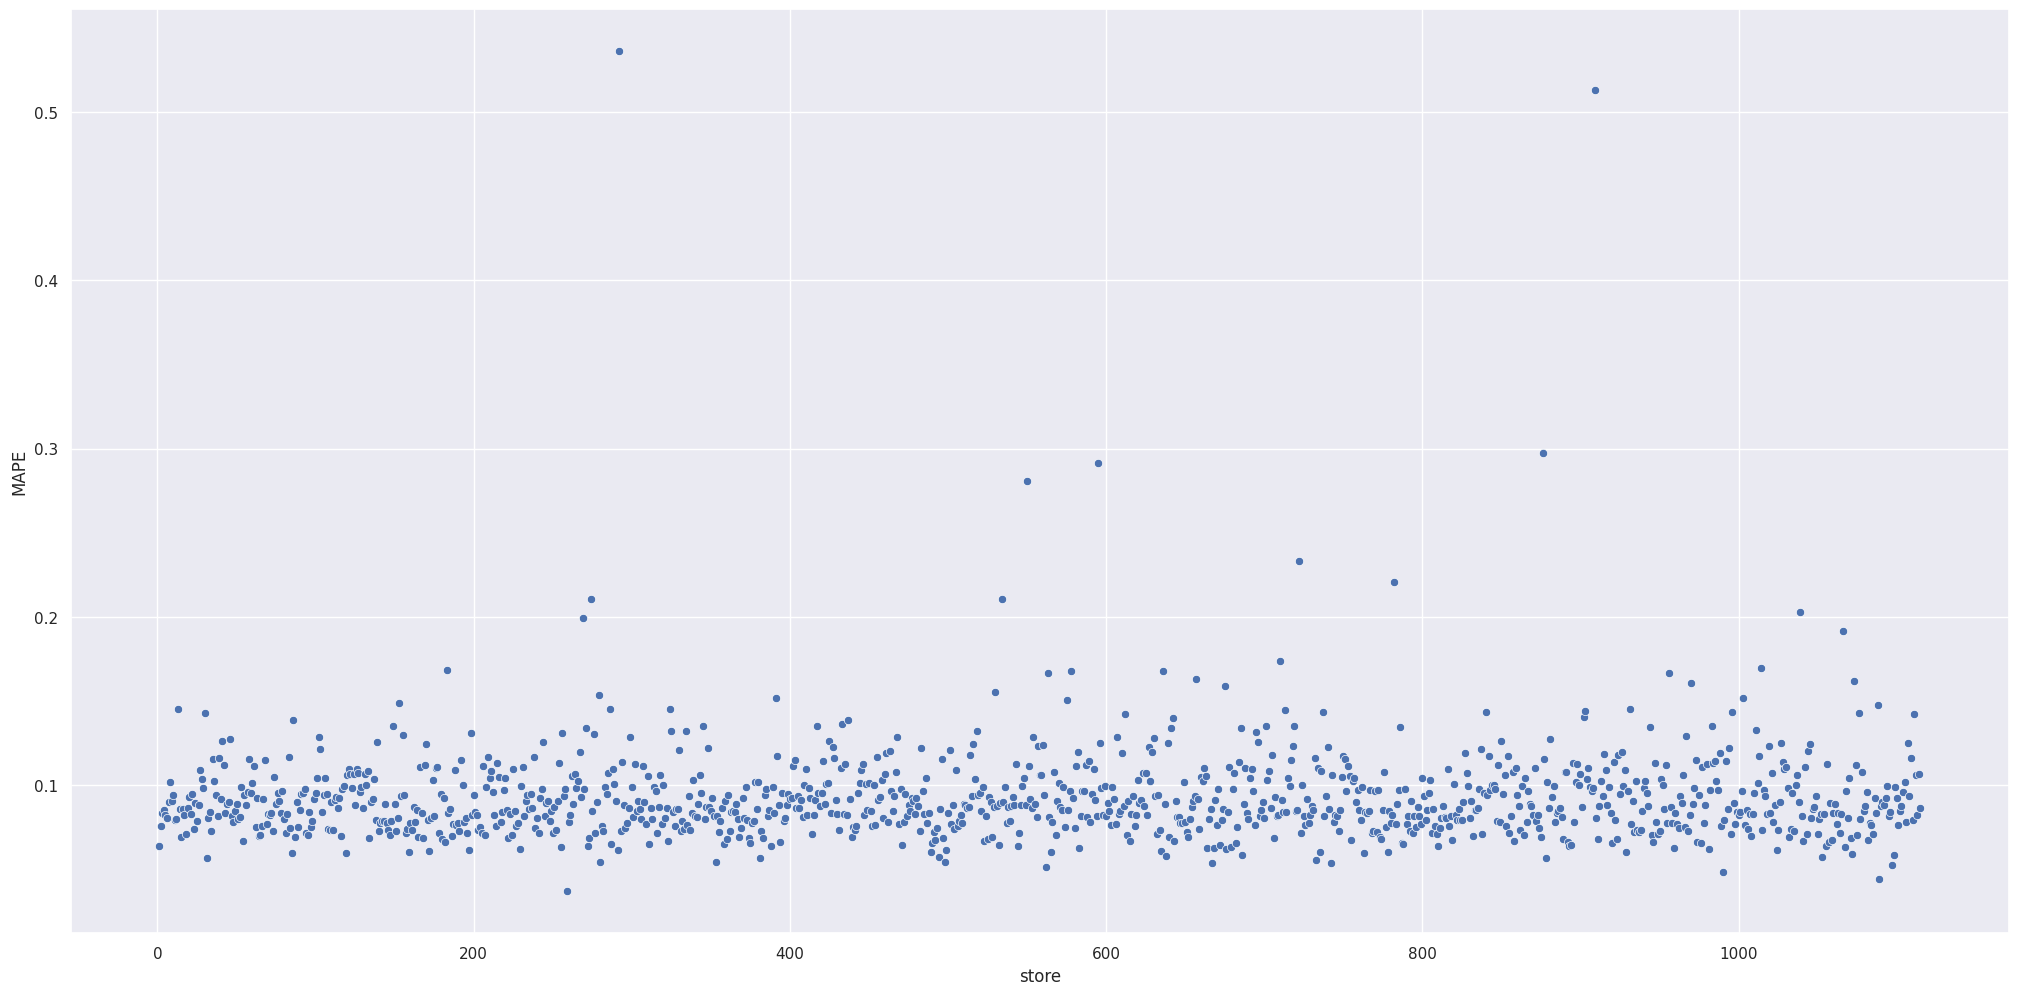

In [102]:
sns.scatterplot( data=df92, x='store', y='MAPE' )

## 9.2. Total Performance

In [103]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$ 283,438,080.00"
1,worst_scenario,"R$ 282,719,324.19"
2,best_scenario,"R$ 284,156,854.24"


## 9.3. Machine Learning Performance

In [104]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

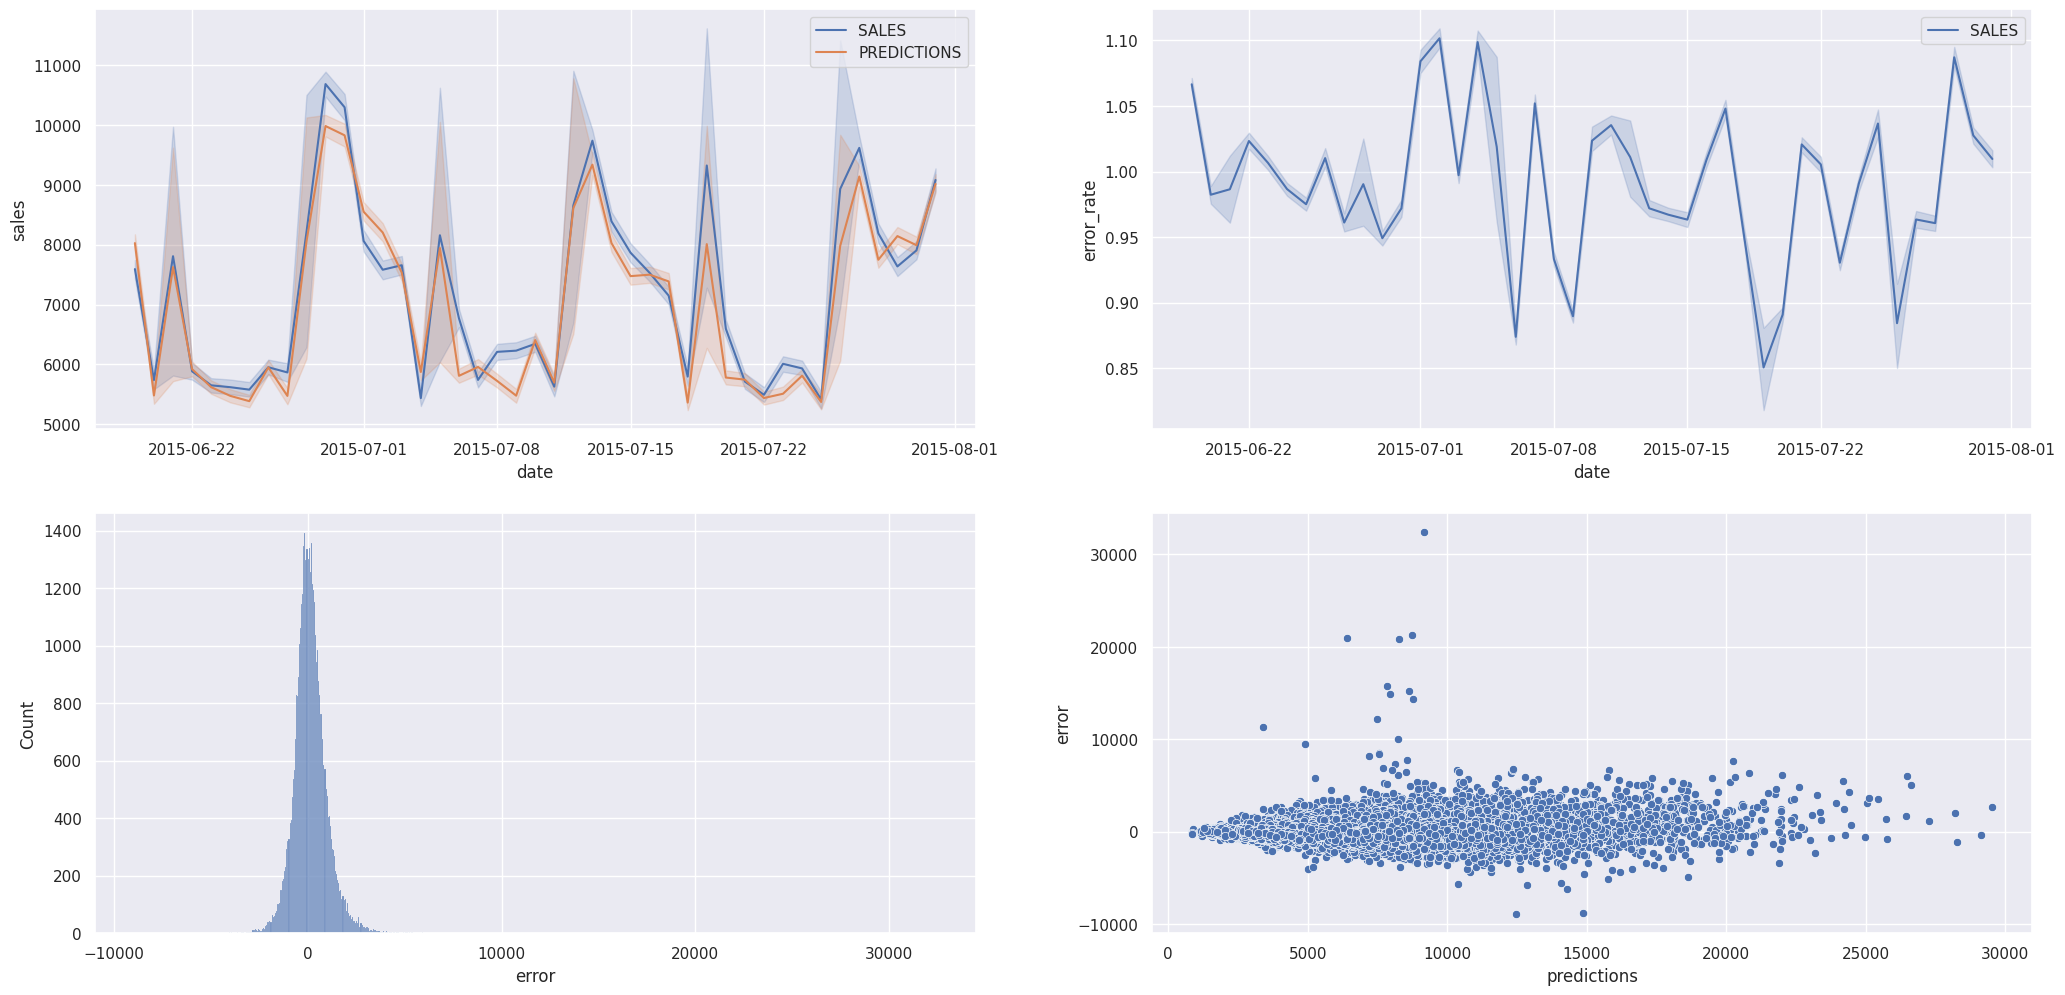

In [105]:
fig, axs = plt.subplots( 2, 2 )

# Grafico 0,0
sns.lineplot( data=df9, x='date', y='sales', ax=axs[0, 0], label='SALES' )
sns.lineplot( data=df9, x='date', y='predictions', ax=axs[0, 0], label='PREDICTIONS' )

# Grafico 0,1
sns.lineplot( data=df9, x='date', y='error_rate', ax=axs[0, 1], label='SALES' )

# Grafico 1,0
sns.histplot( df9['error'], ax=axs[1,0] )

# Grafico 1,1
sns.scatterplot( data=df9, x='predictions', y='error', ax=axs[1,1] )

# 10.0. DEPLOY DO MODELO PARA PRODUÇÃO

In [107]:
pickle.dump( model_xgb, open( '../model/model_xgb_rossmann.pkl', 'wb' ) )

## 10.1. Rossmann Class

In [ ]:
import pickle
import pandas      as pd
import datetime
import inflection

from math          import isnan

class Rossmann( object ):
    def __init__( self ):
        # Define the base path relative to the current file location
        base_path = os.path.dirname(os.path.abspath(__file__))
        
        # Load the scalers using relative paths
        self.scaler_competition_distance = pickle.load( open( os.path.join(base_path, '../../parameter/scaler_competition_distance.pkl'), 'rb' ) )
        self.scaler_competition_time_month = pickle.load( open( os.path.join(base_path, '../../parameter/scaler_competition_time_month.pkl'), 'rb' ) )
        self.scaler_promo_time_week = pickle.load( open( os.path.join(base_path, '../../parameter/scaler_promo_time_week.pkl'), 'rb' ) )
        self.scaler_year = pickle.load( open( os.path.join(base_path, '../../parameter/scaler_year.pkl'), 'rb' ) )
        self.scaler_store_type = pickle.load( open( os.path.join(base_path, '../../parameter/store_type_scaler.pkl'), 'rb' ) )

    def data_cleaning( self, data ):

        # RENAME COLUMNS
        cols_old = list(df1.columns)
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        df1.columns = cols_new

        # CONVERT DATE COLUMN TO DATETIME
        df1['date'] = pd.datetime( df1['date'] )

        # FILL OUT NA
        
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if isnan( x ) else x )
        
        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( 
            lambda x: x['date'].month 
                if isnan( x['competition_open_since_month'] ) 
                else x['competition_open_since_month'],
            axis=1
        )
        
        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( 
            lambda x: x['date'].year 
                if isnan( x['competition_open_since_year'] ) 
                else x['competition_open_since_year'],
            axis=1
        )
        
        # promo2_since_week
        df1['promo2_since_week'] = df1.apply( 
            lambda x: x['date'].week 
                if isnan( x['promo2_since_week'] ) 
                else x['promo2_since_week'],
            axis=1
        )
        
        # promo2_since_year
        df1['promo2_since_year'] = df1.apply( 
            lambda x: x['date'].year
                if isnan( x['promo2_since_year'] ) 
                else x['promo2_since_year'],
            axis=1
        )
        
        # promo_interval
        month_map = { 1: 'Jan', 2: ' Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                      7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'
                    }
        df1['promo_interval'] = df1['promo_interval'].fillna(0)
        
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1 
                if x['month_map'] in x['promo_interval'].split( ',' ) else 0,
            axis=1 
        )

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
        
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

        return df1


    def feature_engineering( self, df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
        # competition since
        df2['competition_since'] = df2.apply(
            lambda x: datetime.datetime( 
                year=x['competition_open_since_year'],
                month=x['competition_open_since_month'],
                day=1
            ),
            axis=1
        )
        df2['competition_time_month'] = ( 
            ( df2['date'] - df2['competition_since'] ) / 30 
            ).apply( lambda x: x.days ).astype( int )
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )
        
        # assortment
        assortment_map = {
            'a': 'basic',
            'b': 'extra',
            'c': 'extended'
        }
        df2['assortment'] = df2['assortment'].map(assortment_map)
        
        # state holiday
        state_holiday_map = {
            'a': 'public holiday',
            'b': 'Easter holiday',
            'c': 'Christmas',
            '0': 'regular_day'
        }
        df2['state_holiday'] = df2['state_holiday'].map(state_holiday_map)
        
        # FILTERING
        df2 = df2[( df2['open'] != 0 ) & ( df2['sales'] > 0 )]
        
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )

        return df2

    def data_preparation( self, df5 ):
        
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )
        
        # competition time month
        df5['competition_time_month'] = self.scaler_competition_time_month.transform( df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.scaler_promo_time_week.transform( df5[['promo_time_week']].values )

        # year 
        df5['year'] = self.scaler_year.transform( df5[['year']].values )
        
        ### 5.3.1. Encoding
        
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int )
        
        # store_type - Label Encoding
        df5['store_type'] = self.scaler_store_type.transform( df5['store_type'] )
        
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        ### 5.3.3. Nature Transformation
        
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
        
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
        
        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        cols_selected_boruta = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance',
                                 'competition_open_since_month', 'competition_open_since_year', 'promo2',
                                 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                                 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos',
                                 'month_sin', 'day_sin', 'day_cos', 'week_of_year_cos', 'week_of_year_sin'
                                ]
        
        return df5[cols_selected_boruta]

## 10.2. API Handler

In [ ]:
import pandas as pd
import pickle

from rossmann.Rossmann import Rossmann
from flask import Flask, requests, Response

# loading model
model = pickle.load( open( 'model/model_xgb_rossmann.pkl', 'rb' ) )

app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()

    if test_json:
        if isinstace( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instancia da classe Rossmann
        pipeline = Rossmann()
    
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # preparation
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3. API Tester

In [16]:
import requests

In [4]:
# loading test dataset
df10 = pd.read_csv( '../data/test.csv' )

In [40]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for predicition
df_test = df_test[df_test['Store'].isin([24, 12, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [41]:
# API Call

url = 'http://0.0.0.0:5000/rossmann/predict'
header = { 'Content-type': 'application/json' }

r = requests.post( url=url, data=data, headers=header )

print( f'Status Code {r.status_code}' )

Status Code 200


In [42]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [43]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( f"Store Number {d2.loc[i, 'store']} will sell {d2.loc[i, 'prediction']:,.2f} in the next 6 weeks" )

Store Number 12 will sell 300,745.88 in the next 6 weeks
Store Number 22 will sell 178,900.23 in the next 6 weeks
Store Number 24 will sell 380,656.65 in the next 6 weeks
